In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PARAPHRASER

In [ ]:
!git clone https://github.com/tagoyal/sow-reap-paraphrasing.git

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("/content/drive/My Drive/sow-reap-data-resources-models", ".")

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("/content/sow-reap-paraphrasing", ".")

In [ ]:
!python generate_paraphrases_gt_reap.py

-1
THCudaCheck FAIL file=/pytorch/aten/src/THC/THCGeneral.cpp line=47 error=100 : no CUDA-capable device is detected
Traceback (most recent call last):
  File "generate_paraphrases_gt_reap.py", line 183, in <module>
    main(args)
  File "generate_paraphrases_gt_reap.py", line 78, in main
    torch.cuda.set_device(device_id)
  File "/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py", line 281, in set_device
    torch._C._cuda_setDevice(device)
  File "/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py", line 190, in _lazy_init
    torch._C._cuda_init()
RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /pytorch/aten/src/THC/THCGeneral.cpp:47


# dynamic network benchmark

In [ ]:
!pip install leidenalg
!pip install cdlib
!pip install python-igraph
!pip install infomap

from numpy import genfromtxt
import numpy as np
import networkx as nx
import cdlib
from cdlib import evaluation, algorithms
import leidenalg
import igraph as ig
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import infomap

# bipartite

In [ ]:
!pip install git+https://github.com/nkoub/multinetx.git

In [ ]:
import numpy as np
import multinetx as mx


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=300, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)


if __name__ == '__main__':

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    LayeredNetworkGraph([A, B], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
    ax.set_axis_off()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

n=5
g = nx.erdos_renyi_graph(4*n, p=0.1)

In [ ]:
g.edges()

EdgeView([(0, 1), (0, 5), (0, 6), (0, 18), (1, 2), (1, 6), (1, 17), (2, 4), (2, 17), (3, 15), (4, 8), (5, 6), (5, 16), (6, 9), (6, 15), (6, 18), (9, 18), (11, 12), (12, 14), (12, 17), (14, 16)])

# ml


In [ ]:
with open('/content/BKFRAT.txt') as file_in:
    lines = []
    for line in file_in:
        lines.append(line)

In [ ]:
layerx = []
for i in range(len(lines)):
    if i == len(lines)-1:
        temp = lines[i]
        temp = temp.split('\t')
        layerx.append([int(x) for x in temp])
    else:
        temp = lines[i][:-1]
        temp = temp.split('\t')
        layerx.append([int(x) for x in temp])

In [ ]:
l1=[]
l2=[]
for i in range(len(layerx)):
    if layerx[i][2]==1:
        l1.append((layerx[i][0],layerx[i][1]))
    if layerx[i][2]==2:
        l2.append((layerx[i][0],layerx[i][1]))

In [ ]:
A = nx.Graph()
B = nx.Graph()


In [ ]:
A.add_edges_from(l1)
B.add_edges_from(l2)

In [ ]:
node_labels = {nn : str(nn) for nn in range(max(max([x[0] for x in layerx]),max([x[1] for x in layerx]))+1)}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=300, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)


if __name__ == '__main__':

    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [40.0, 40.0]
    plt.rcParams['figure.dpi'] = 200
    ax = fig.add_subplot(111, projection='3d')
    LayeredNetworkGraph([A, B], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
    ax.set_axis_off()
    plt.show()

## load data


In [ ]:
G = nx.read_edgelist('/content/34karate.csv', delimiter=',', nodetype=int)
L=G

In [ ]:
import networkx as nx

df = pd.read_csv('/content/114football.csv',header=None)
G = nx.read_edgelist('/content/114football.csv', delimiter=',', nodetype=str)
L=G

In [ ]:
li1 = [x for x in set(df[0].values)]
li2 = [x for x in set(df[1].values)]
in_first = set(li1)
in_second = set(li2)
in_second_but_not_in_first = in_second - in_first
result = li1 + list(in_second_but_not_in_first)

In [ ]:
dic={}
p=-1
for i in result:
    p=p+1
    dic[i]=p

In [ ]:
import ast

file = open("/content/football.txt", "r")

contents = file.read()
dictionary = ast.literal_eval(contents)

file.close()

print(type(dictionary))

print(dictionary)
dic = dictionary

<class 'dict'>
{'BostonCollege': 0, 'Kent': 1, 'Buffalo': 2, 'Northwestern': 3, 'Mississippi': 4, 'Nevada': 5, 'Tulane': 6, 'Minnesota': 7, 'SanDiegoState': 8, 'BrighamYoung': 9, 'Stanford': 10, 'KansasState': 11, 'Louisville': 12, 'NewMexicoState': 13, 'TexasElPaso': 14, 'Missouri': 15, 'NorthTexas': 16, 'Marshall': 17, 'NewMexico': 18, 'Clemson': 19, 'CentralFlorida': 20, 'Auburn': 21, 'ColoradoState': 22, 'Florida': 23, 'TexasTech': 24, 'Rice': 25, 'Oregon': 26, 'MississippiState': 27, 'NotreDame': 28, 'SouthernCalifornia': 29, 'Oklahoma': 30, 'SouthernMethodist': 31, 'MiamiOhio': 32, 'Wyoming': 33, 'OhioState': 34, 'Texas': 35, 'Utah': 36, 'VirginiaTech': 37, 'Baylor': 38, 'Kansas': 39, 'Michigan': 40, 'BoiseState': 41, 'Pittsburgh': 42, 'Colorado': 43, 'WestVirginia': 44, 'NorthCarolina': 45, 'FresnoState': 46, 'WashingtonState': 47, 'SouthCarolina': 48, 'Toledo': 49, 'LouisianaTech': 50, 'TexasA&M': 51, 'SanJoseState': 52, 'Tennessee': 53, 'Rutgers': 54, 'WakeForest': 55, 'Illino

In [ ]:
def readDict(filename, sep):
    with open(filename, "r") as f:
        dict = {}
        for line in f:
            values = line.split(sep)
            dict[values[0]] = {int(x) for x in values[1:len(values)]}
        return(dict)

data = readDict('/content/dolphin.txt',sep=',')

In [ ]:
reading()

In [ ]:
# mydata = genfromtxt('/content/drive/My Drive/dyno/Adja_1.csv', delimiter=',')           #graph
# G  =  nx.from_numpy_matrix(mydata)
# L  =  nx.from_numpy_matrix(mydata)
# L.add_edge(1150,67)




# com = np.genfromtxt('/content/drive/My Drive/dyno/Final_Community_1.csv', delimiter=',')
# community = []
# comm=[]
# for j in range(len(com)):
#     for w in com[j]:
#         if (int(w)) != 0 :
#             comm.append(w)
#     community.append(comm)
#     comm=[]
# rcommunity= np.arange(len(community))
# rcommunity = rcommunity.tolist()
# for p in range(len(comm unity)):
#     rcommunity[p]= [x-1 for x in community[p]]
# c1 = cdlib.NodeClustering(rcommunity,G,method_name="kalantarislab",overlap=True)         #NodeClusterin object

In [ ]:
m=[]
n=[]
for i in df[0]:
    m.append(dic[i])
for i in df[1]:
    n.append(dic[i])
ff = {"src":m,"trg":n}
ss = pd.DataFrame(ff)

ss.to_csv('foot.csv', header=False, index=False)

In [ ]:
with open('dolphin.txt', 'w') as f:
    print(dic, file=f)

In [ ]:
L = nx.algor()

In [ ]:
from cdlib import evaluation, algorithms
import leidenalg
import igraph as ig
import networkx as nx
from networkx.algorithms import community

In [ ]:
a1 = algorithms.nmnf(L)

In [ ]:
a2 = algorithms.big_clam(L)

In [ ]:
a3 = algorithms.kclique(L, k=3)

In [ ]:
a4 = algorithms.louvain(L)

In [ ]:
a5 = algorithms.leiden(L) #foss

In [ ]:
a6 = algorithms.label_propagation(L)

In [ ]:
# xxavg_embeddedness =[]
# xxedges_inside =[]
# xxcut_ratio =[]
# xxhub_dominance =[]
# xxflake_odf =[]
# xxavg_odf =[]

len(xxavg_embeddedness)


In [ ]:
xxz_modularity =[]
xxmodularity_density=[]
xxerdos_renyi_modularity=[]
xxlink_modularity=[]
xxnewman_girvan_modularity=[]
xxsurprise=[]
xxconductance=[]
xxaverage_internal_degree=[]
xxtriangle_participation_ratio=[]
xxavg_transitivity=[]
xxsignificance=[]
xxedges_inside =[]
xxcut_ratio =[]
xxflake_odf =[]
xxavg_odf =[]

c = [a1,a2,a3,a4,a6]

for i in c:
    try:
        xxz_modularity.append(i.z_modularity().score)
    except:
        print(i)
    try:
        xxmodularity_density.append(i.modularity_density().score)
    except:
        pp=0
    try:
        xxerdos_renyi_modularity.append(i.erdos_renyi_modularity().score)
    except:
        pp=0
    try:
        xxlink_modularity.append(i.link_modularity().score)
    except:
        pp=0
    try:
        xxnewman_girvan_modularity.append(i.newman_girvan_modularity().score)
    except:
        pp=0
    try:
        xxsurprise.append(i.surprise().score)
    except:
        pp=0
    try:
        xxconductance.append(i.conductance().score)
    except:
        pp=0
    try:
        xxaverage_internal_degree.append(i.average_internal_degree().score)
    except:
        pp=0
    try:
        xxtriangle_participation_ratio.append(i.triangle_participation_ratio().score)
    except:
        pp=0
    try:
        xxavg_transitivity.append(evaluation.avg_transitivity(G,i).score)
    except:
        pp=0
    try:
        xxsignificance.append(i.significance().score)
    except:
        pp=0
    
    try:
        xxedges_inside.append(i.edges_inside().score)
    except:
        pp=0
    try:
        xxcut_ratio.append(i.cut_ratio().score)
    except:
        pp=0
    try:
        xxflake_odf.append(i.flake_odf().score)
    except:
        pp=0
    try:
        xxavg_odf.append(i.avg_odf().score)
    except:
        pp=0

/usr/local/lib/python3.6/dist-packages/cdlib/evaluation/fitness.py:807: RuntimeWarning: divide by zero encountered in log
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
/usr/local/lib/python3.6/dist-packages/cdlib/evaluation/fitness.py:807: RuntimeWarning: invalid value encountered in double_scalars
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))


In [ ]:
d={'z_modularity': xxz_modularity,'modularity_density':xxmodularity_density,'erdos_renyi_modularity':xxerdos_renyi_modularity,'link_modularity':xxlink_modularity,'newman_girvan_modularity':xxnewman_girvan_modularity,'surprise':xxsurprise,'conductance':xxconductance,'average_internal_degree':xxaverage_internal_degree,'triangle_participation_ratio':xxtriangle_participation_ratio,'avg_transitivity':xxavg_transitivity,'significance':xxsignificance,'edges_inside':xxedges_inside,'cut_ratio':xxcut_ratio,'flake_odf':xxflake_odf,'avg_odf':xxavg_odf}

In [ ]:
# 'avg_transitivity':xxavg_transitivity,

In [ ]:
data = pd.DataFrame(d,index=['nmnf', 'big_clam' ,'kclique' ,'louvain', 'label_propagation'])

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
data

z_modularity  modularity_density  ...  flake_odf   avg_odf
nmnf                   2.203330           -6.523056  ...   0.735000  3.121667
big_clam               0.986691            0.379286  ...   0.025000  0.728571
kclique                0.668806            0.396622  ...   0.166667  1.480000
louvain                1.361197            0.837546  ...   0.062500  1.179167
label_propagation      1.115569            0.559757  ...   0.000000  1.136111

[5 rows x 15 columns]

In [ ]:
data.to_csv('karate.csv')

In [ ]:
nx.write_edgelist(L, "karate.edgelist")

In [ ]:
# xz_modularity 
# xmodularity_density
# xerdos_renyi_modularity
# xlink_modularity
# xnewman_girvan_modularity
# xsurprise ==========================
# xconductance
# xaverage_internal_degree
# xtriangle_participation_ratio
# xavg_transitivity
# xsignificance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


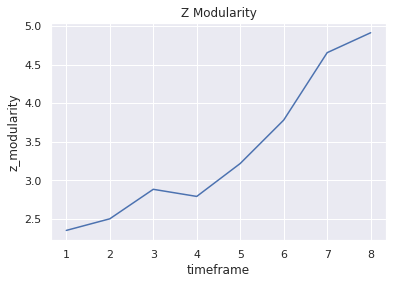

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("Z Modularity")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xz_modularity)
ax.set(xlabel='timeframe', ylabel='z_modularity')
plt.show()

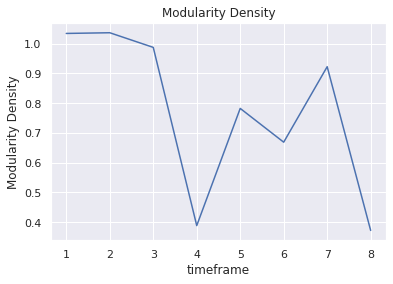

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("Modularity Density")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xmodularity_density)
ax.set(xlabel='timeframe', ylabel='Modularity Density')
plt.show()

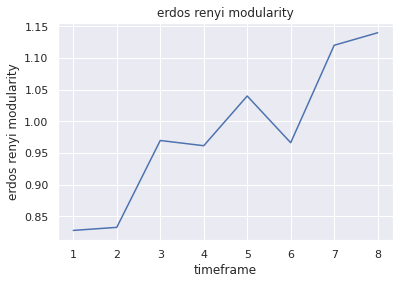

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("erdos renyi modularity")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xerdos_renyi_modularity)
ax.set(xlabel='timeframe', ylabel='erdos renyi modularity')
plt.show()

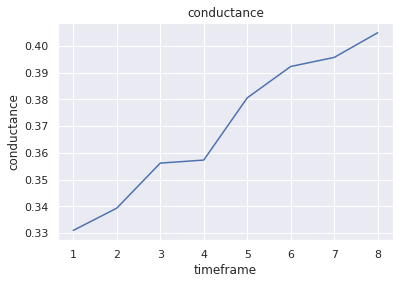

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("conductance")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xconductance)
ax.set(xlabel='timeframe', ylabel='conductance')
plt.show()

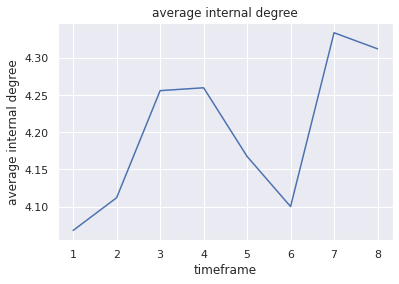

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("average internal degree")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xaverage_internal_degree)
ax.set(xlabel='timeframe', ylabel='average internal degree')
plt.show()

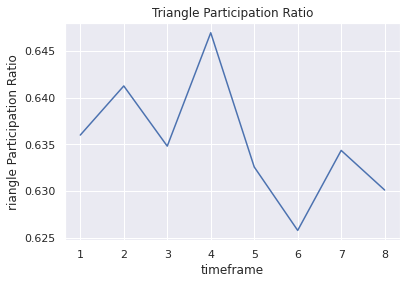

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("Triangle Participation Ratio")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xtriangle_participation_ratio)
ax.set(xlabel='timeframe', ylabel='riangle Participation Ratio')
plt.show()

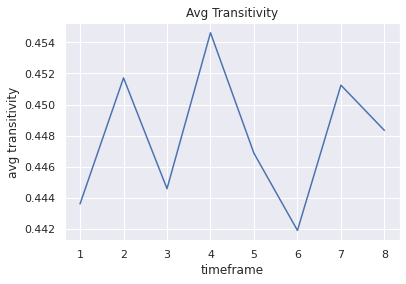

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("Avg Transitivity")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xavg_transitivity)
ax.set(xlabel='timeframe', ylabel='avg transitivity')
plt.show()

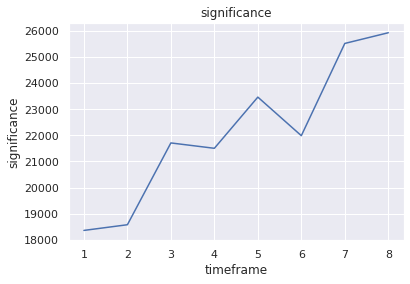

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("significance")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xsignificance)
ax.set(xlabel='timeframe', ylabel='significance')
plt.show()

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("Link Modularity")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xlink_modularity)
ax.set(xlabel='timeframe', ylabel='Link_ Mdularity')
plt.show()

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.title("Newman Girvan Modularity")
ax = sns.lineplot(x=[1,2,3,4,5,6,7,8] ,y=xnewman_girvan_modularity)
ax.set(xlabel='timeframe', ylabel='Newman Girvan Modularity')
plt.show()

In [ ]:
from cdlib.algorithms import eva
from cdlib import evaluation
import random
l1 = ['A', 'B', 'C', 'D']
l2 = ["E", "F", "G"]
g_attr = nx.barabasi_albert_graph(100, 5)
labels=dict()
for node in g_attr.nodes():
   labels[node]={"l1":random.choice(l1), "l2":random.choice(l2)}
communities = eva(G, labels, alpha=0.5)
pur = evaluation.avg_transitivity(communities,g_attr)

In [ ]:
a1

In [ ]:
evaluation.purity(a1)

In [ ]:
c1.z_modularity().score
c1.modularity_density().score
c1.erdos_renyi_modularity().score
c1.link_modularity().score
c1.newman_girvan_modularity().score
c1.surprise().score
c1.conductance().score
c1.average_internal_degree().score
c1.triangle_participation_ratio().score
c1.purity().score
c1.avg_transitivity().score
c1.significance().score

2.3513613494949603

## covering only the piece of network that is in our CD model

In [ ]:
# for i in range(1,9):
mydata = genfromtxt('/content/drive/My Drive/dyno/Adja_1.csv', delimiter=',')           #graph
G  =  nx.from_numpy_matrix(mydata)
G.add_edge(1150,67)
com = np.genfromtxt('/content/drive/My Drive/dyno/Final_Community_1.csv', delimiter=',')
community = []
comm=[]
for j in range(len(com)):
    for w in com[j]:
        if (int(w)) != 0 :
            comm.append(w)
    community.append(comm)
    comm=[]
rcommunity= np.arange(len(community))
rcommunity = rcommunity.tolist()
for p in range(len(community)):
    rcommunity[p]= [x-1 for x in community[p]]

for i in range(len(rcommunity)):
    G.remove_nodes_from([x for x in G.nodes() if x in rcommunity[i]])



In [ ]:
c1.purity()

AttributeError: ignored

In [ ]:
dff[dff.role == '0'].shape

(7416, 13)

## metrics on our data

In [ ]:
# # modularity based ones

# z_modularity
Cour.append(c1.z_modularity().score)
Cnmnf.append(a1.z_modularity().score)
Cbig_clam.append(a2.z_modularity().score)
# Clfm.append(a3.z_modularity().score
Ckclique.append(a4.z_modularity().score)
Clouvain.append(a5.z_modularity().score)
# Cleiden.append(a6.z_modularity().score
Clabel_propagation.append(a7.z_modularity().score)
# Cinfomap.append(a8.z_modularity().score

# # modularity_density
# mod1 = c1.modularity_density()
# mod2 = a1.modularity_density()

# # modularity_density
# mod1 = c1.erdos_renyi_modularity()
# mod2 = a1.erdos_renyi_modularity()

# # modularity_density
# mod1 = c1.link_modularity()
# mod2 = a1.link_modularity()

# # modularity_density
# mod1 = c1.newman_girvan_modularity()
# mod2 = a1.newman_girvan_modularity()
# #=-=-=-=-=-=-=-=-=-=-=-=-=

# # conductance(L)
# mod1 = c1.conductance()
# mod2 = a1.conductance()

# # surprise
# mod1 = c1.surprise()
# mod2 = a1.surprise()

# #average_internal_degree(L)
# mod1 = c1.average_internal_degree()
# mod2 = a1.average_internal_degree()

# # triangle participation ratio(L)
# mod1 = c1.triangle_participation_ratio()
# mod2 = a1.triangle_participation_ratio()

# # significance
# mod1 = c1.significance()
# mod2 = a1.significance()

# # transitivity(L)
# mod1 = c1.avg_transitivity()
# mod2 = a1.avg_transitivity()

# # purity
# mod1 = c1.purity()
# mod2 = a1.purity()
 
print(mod1)
print(mod2)

FitnessResult(min=None, max=None, score=2.3513613494949603, std=None)
FitnessResult(min=None, max=None, score=1.1800580296219856, std=None)


## metrics on ground truth data

In [ ]:
#ground truth


# F-measure


# Adjusted Rand Index           --> OMEGA

 
# Normalized Mutual Information --> overlapping Normalized Mutual Information (onmi)


In [ ]:
def onmi(cover, coverRef, allNodes=None, variant="LFK"):  # cover and coverRef should be list of set, no community ID
    """
    Compute Overlapping NMI
    This implementation allows to compute 3 versions of the overlapping NMI
    LFK: The original implementation proposed by Lacichinetti et al.(1). The normalization of mutual information is done community by community
    MGH: In (2), McDaid et al. argued that the original NMI normalization was flawed and introduced a new (global) normalization by the max of entropy
    MGH_LFK: This is a variant of the LFK method introduced in (2), with the same type of normalization but done globally instead of at each community
    Results are checked to be similar to the C++ implementations by the authors of (2): https://github.com/aaronmcdaid/Overlapping-NMI
    :param cover: set of set of nodes
    :param coverRef:set of set of nodes
    :param allNodes:
    :param variant:
    :param adjustForChance:
    :return:
    :Reference:
    1. Lancichinetti, A., Fortunato, S., & Kertesz, J. (2009). Detecting the overlapping and hierarchical community structure in complex networks. New Journal of Physics, 11(3), 033015.
    2. McDaid, A. F., Greene, D., & Hurley, N. (2011). Normalized mutual information to evaluate overlapping community finding algorithms. arXiv preprint arXiv:1110.2515. Chicago
    """
    if (len(cover) == 0 and len(coverRef) != 0) or (len(cover) != 0 and len(coverRef) == 0):
        return 0
    if cover == coverRef:
        return 1

    if allNodes is None:
        allNodes = {n for c in coverRef for n in c}
        allNodes |= {n for c in cover for n in c}

    if variant == "LFK":
        HXY = coverConditionalEntropy(cover, coverRef, allNodes, normalized=True)
        HYX = coverConditionalEntropy(coverRef, cover, allNodes, normalized=True)
    else:
        HXY = coverConditionalEntropy(cover, coverRef, allNodes)
        HYX = coverConditionalEntropy(coverRef, cover, allNodes)

    HX = coverEntropy(cover, allNodes)
    HY = coverEntropy(coverRef, allNodes)

    NMI = -10
    if variant == "LFK":
        NMI = 1 - 0.5 * (HXY + HYX)
    elif variant == "MGH_LFK":
        NMI = 1 - 0.5 * (HXY / HX + HYX / HY)
    elif variant == "MGH":
        IXY = 0.5 * (HX - HXY + HY - HYX)
        NMI = IXY / (max(HX, HY))
    if NMI < 0 or NMI > 1 or math.isnan(NMI):
        print("NMI: %s  from %s %s %s %s " % (NMI, HXY, HYX, HX, HY))
        raise Exception("incorrect NMI")
    return NMI

# Create graph from Adjacency Matrix

In [ ]:
# !pip install python-igraph
from numpy import genfromtxt
import numpy as np
import networkx as nx
# from igraph import *

mydata = genfromtxt('/content/drive/MyDrive/dyno/Adja_3.csv', delimiter=',')
G  =  nx.from_numpy_matrix(mydata)
nx.write_graphml(G, 'graphmldr.graphml')
nx.write_edgelist(G,"t1.edgelist")

# Networkx Visualize the whole graph 

In [ ]:

nis_connected(G)

NameError: ignored

In [ ]:
G.number_of_nodes()

1862

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(num=None, figsize=(130, 130), dpi=50)

options = {
    'node_color': 'red',
    'node_size': 50,
    'line_color': 'black',
    'linewidths': 20,
    'width': 2,
}
nx.draw(G, **options)
plt.show()
# plt.savefig('graph.pdf',dpi=180 ,bbox_inches="tight")


NameError: ignored

<Figure size 6500x6500 with 0 Axes>

In [ ]:
G

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


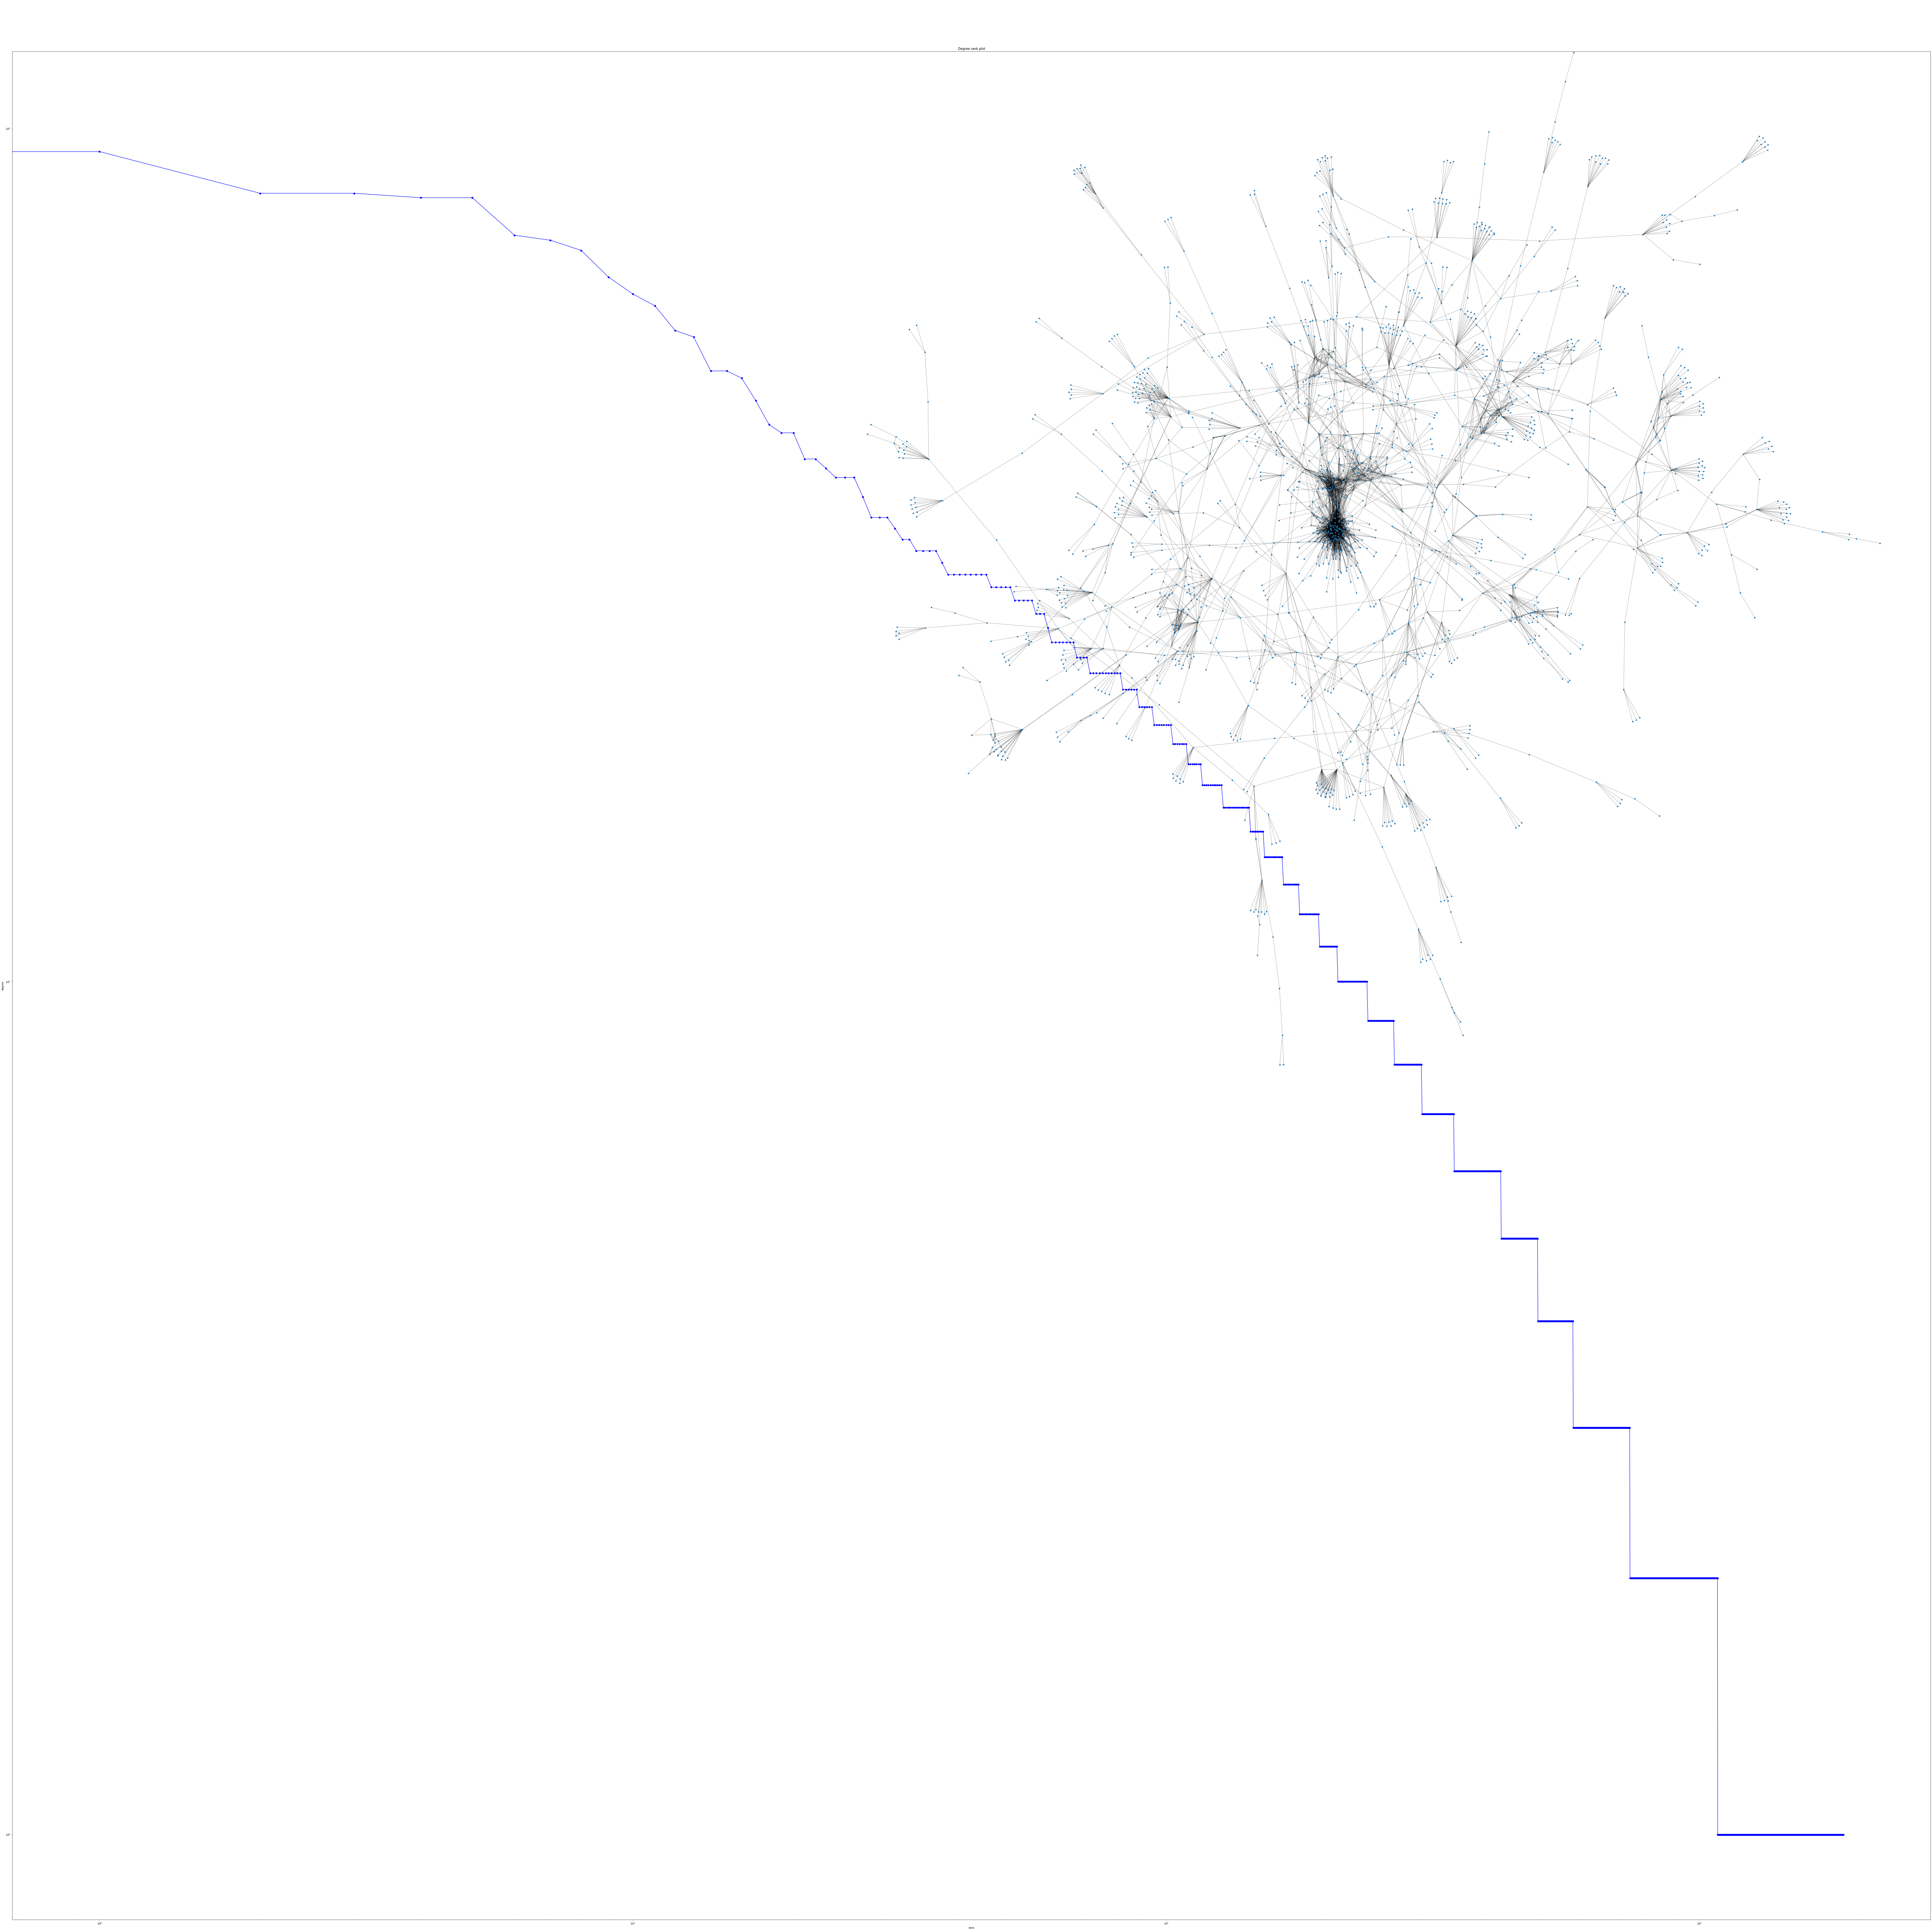

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

degree = nx.degree(G)
degr = []
for j in range(len(degree)):
    degr.append(degree[j])

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

degree_sequence=sorted(degr,reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(num=None, figsize=(130, 130), dpi=50)
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])
Gcc=sorted(connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc,pos,node_size=20)
nx.draw_networkx_edges(Gcc,pos,alpha=0.4)
plt.savefig("degree_histogram.png")
plt.show()

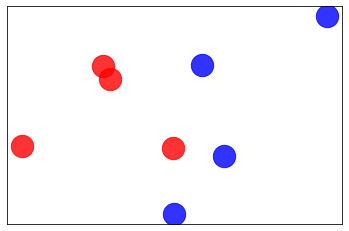

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1,2,3],
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[4,5,6,7],
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

# Create datasets

## Drivers DATASET

In [ ]:
dff.head(2)

Unnamed: 0  id community role  ...  diff_to_vol  dist-poss  timestep  heart
0           0   1      [16]    f  ...      0.87496        1.0         1      1
1           1   2      [25]    f  ...      1.00000        1.0         1      1

[2 rows x 13 columns]

In [ ]:
import numpy as np
import networkx as nx
import networkx

a ='/content/time/Adja_8.csv'
b ='/content/time/Final_Community_8.csv'
c='/content/time/Follower_Nodes_8.csv'
d='/content/time/Volunteer_Sorted_by_Closeness_8.csv'
e="/content/time/Follower_Diffusion_posibility_Value_in_Community_8.csv"
f="/content/time/Follower_Distance_Value_in_Community_8.csv"

mydata = np.genfromtxt(a, delimiter=',')
G  =  nx.from_numpy_matrix(mydata)
com = np.genfromtxt(b, delimiter=',')
community = []
comm=[]
for j in range(len(com)):
    for i in com[j]:
        if (int(i)) != 0 :
            comm.append(i)
    community.append(comm)
    comm=[]

In [ ]:

#col2    
col2 = np.arange(1,1863)
col2 = col2.tolist()
p = []
for i in community:
    for j in i:
        p.append(j)
for i in col2:
    if i not in p:
        col2[i-1] = 0
for i in community:
    for j in i:
        col2[int(j-1)] = []      
k=0
for i in community:
    k=k+1
    for j in i:
        col2[int(j-1)].append(k)

#col3 - role

fol = np.genfromtxt(c,delimiter=',')
vol = np.genfromtxt(d,delimiter=',')

col3 = np.arange(1,1863)
col3 = col3.tolist()
p = []
for i in community:
    for j in i:
        p.append(j)

for i in col3:
    if i not in p:
        col3[i-1] = 0
        
for i in fol:
    for j in i:
        col3[int(j-1)] = 'f'

for i in vol:
    for j in i:
        col3[int(j-1)] = 'v'    

# col4
bet  =  nx.betweenness_centrality(G)
deg  =  nx.degree_centrality(G)
clo  =  nx.closeness_centrality(G)

eig  =  nx.eigenvector_centrality(G)

#-------------------------------
degree  =  nx.degree(G)
#-------------------------------
cbet = []
cdeg = []
cclo = []
ceig = []
for i in (bet.values()):
    cbet.append(i)
for i in (deg.values()):
    cdeg.append(i)
for i in (clo.values()):
    cclo.append(i)   
for i in (eig.values()):
    ceig.append(i)    
degr = []
for j in range(len(degree)):
    degr.append(degree[j])


dif = np.genfromtxt(e, delimiter=',')
dis = np.genfromtxt(f, delimiter=',')
# col 9
col9 = np.arange(1,1863)
col9 = col9.tolist()
#not fols
p = []
for i in community:
    for j in i:
        p.append(j)
for i in col9:
    if i not in p:
        col9[i-1] = 0
for i in vol:
    for j in i:
        col9[int(j-1)] = 2
#now diff in fols
p=-1
for i in dif:
    p=p+1
    q=-1
    for j in i:
        q = q+1
        col9[int(fol[p][q])-1] = dif[p][q]

# col 10
col10 = np.arange(1,1863)
col10 = col10.tolist()
#not fols
p = []
for i in community:
    for j in i:
        p.append(j)
for i in col10:
    if i not in p:
        col10[i-1] = 0
for i in vol:
    for j in i:
        col10[int(j-1)] = 2
#now dist in fols
p=-1
for i in dis:
    p=p+1
    q=-1
    for j in i:
        q = q+1
        col10[int(fol[p][q])-1] = dis[p][q]


        

## community DATASET



In [ ]:
#col2    
col2 = np.arange(1,1863)
col2 = col2.tolist()
p = []
for i in community:
    for j in i:
        p.append(j)
for i in col2:
    if i not in p:
        col2[i-1] = 0
for i in community:
    for j in i:
        col2[int(j-1)] = []      
k=0
for i in community:
    k=k+1
    for j in i:
        col2[int(j-1)].append(k)

        
rcommunity= np.arange(len(community))
rcommunity = rcommunity.tolist()
for i in range(len(community)):
    rcommunity[i]= [x-1 for x in community[i]]

#col1 id
ccol1 = np.arange(len(community)).tolist()
ccol1 = [x+1 for x in ccol1]
#ccol2 size fol
#ccol3 size vol
fol = np.genfromtxt(c,delimiter=',')
vol = np.genfromtxt(d,delimiter=',')
fol = fol.tolist()
vol = vol.tolist()
ccol2 = []
ccol3 = []
for i in range(len(community)):
    ccol2.append(len(fol[0]) - fol[i].count(0))
for i in range(len(community)):
    ccol3.append(len(vol[0]) - vol[i].count(0))

#ccol 4 diameter
ccol4 = []
for i in range(len(rcommunity)):
    G  =  nx.from_numpy_matrix(mydata)
    G.remove_nodes_from([x for x in G.nodes() if x not in rcommunity[i]])
    try :
        ccol4.append(networkx.algorithms.distance_measures.diameter(G))
    except:
        ccol4.append('nan')

#ccol 5 density
ccol5 = []
for i in range(len(rcommunity)):
    G  =  nx.from_numpy_matrix(mydata)
    G.remove_nodes_from([x for x in G.nodes() if x not in rcommunity[i]])
    try :
        ccol5.append(networkx.classes.function.density(G))
    except:
        ccol5.append('nan')

#ccol 6 group_degree_centrality
ccol6=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(rcommunity)):
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in G.nodes() if x not in rcommunity[i]])
    try:
        ccol6.append(networkx.algorithms.centrality.group_degree_centrality(G,SG))
    except:
        ccol6.append('nan')

#ccol 7 group_betweenness_centrality
ccol7=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(rcommunity)):
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in SG.nodes() if x not in rcommunity[i]])
    bet  =  nx.betweenness_centrality(SG)
    ccol7.append(sum(bet.values())/len(rcommunity[i]))

#ccol 8 group_closeness_centrality
import networkx as nx
import networkx
ccol8=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(rcommunity)):
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in G.nodes() if x not in rcommunity[i]])
    try:
        ccol8.append(networkx.algorithms.centrality.group_closeness_centrality(G,SG))
    except:
        ccol8.append('nan')

#ccol 9 ave eig
ccol9=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(rcommunity)):
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in SG.nodes() if x not in rcommunity[i]])
    eig  =  nx.eigenvector_centrality(SG)
    ccol9.append(sum(eig.values())/len(rcommunity[i]))

#col10 boundary
ccol10=[]
t=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(rcommunity)):
    s=[]
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in G.nodes() if x not in rcommunity[i]])
    PG=  nx.from_numpy_matrix(mydata)
    PG.remove_nodes_from([x for x in G.nodes() if x in rcommunity[i]])
    for j in (networkx.algorithms.boundary.edge_boundary(G,SG,PG)):
        s.append(j)
    t.append(s)
for i in t:
    ccol10.append(len(i))    

# col11 eshterakia
q=np.arange(len(community))
q=q.tolist()
for i in range(len(community)):
    q[i]=0
for i in col2:
    if type(i)!=int:
            if len(i)>1:
                for j in i:
                    # print(j)
                    q[j-1] = q[j-1]+1
  
ccol11=q
# edge_boundary

#ccol12 triangles
ccol12=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(rcommunity)):
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in G.nodes() if x not in rcommunity[i]])
    X = nx.triangles(SG).values()
    ccol12.append(sum(X))
    
#ccol13 cliques
ccol13=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(community)):
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in SG.nodes() if x not in rcommunity[i]])
    try:
        ccol13.append((networkx.algorithms.clique.graph_clique_number(SG)))
    except:
        ccol13.append('nan')

# col14 average_shortest_path_length
ccol14=[]
G =  nx.from_numpy_matrix(mydata)
for i in range(len(rcommunity)):
    SG  =  nx.from_numpy_matrix(mydata)
    SG.remove_nodes_from([x for x in SG.nodes() if x not in rcommunity[i]])
    try:
        ccol14.append(networkx.algorithms.shortest_paths.generic.average_shortest_path_length(SG))
    except:
        ccol14.append('nan')

# ccol15
ccol15 = []
for i in dis:
    k=0
    for j in i:
        k = k+j
    ccol15.append(k/len(i))

# ccol16
ccol16 = []
for i in dif:
    k=0
    for j in i:
        k = k+j
    ccol16.append(k/(len(i)))          

#ccol 17 - vol /id
ccol17 = []
for i in range(len(community)):
    ccol17.append('')
k=0
for i in vol:
    for j in i:
        if j!=0:
            ccol17[k] = ccol17[k]+(str(int(j-1)))
            ccol17[k] = ccol17[k]+(',')
    ccol17[k] = ccol17[k][:-1]   
    k = k+1    


In [ ]:
ccom = {'id':ccol1, 'numFol':ccol2 , 'numVol':ccol3 , 'diameter':ccol4,
        'density':ccol5 , 'degCen':ccol6 , 'AVEbetCen':ccol7, 'cloCen':ccol8,
        'AVEeigClo':ccol9, 'boundary':ccol10 ,'moshtarak':ccol11 , 'triangles':ccol12,
        'cliques':ccol13 , 'aveSP':ccol14 , 'aveDis':ccol15 , 'aveDiff':ccol16, 'vol_ids':ccol17}
ccom = pd.DataFrame(ccom)

In [ ]:
pd.DataFrame.to_csv(ccom,"/content/tard/communities_8.csv")


# Visualize each community

In [ ]:
#plot communities

import matplotlib.pyplot as plt
import numpy as np
b='/content/drive/My Drive/dyno/Final_Community_1.csv'
com = np.genfromtxt(b, delimiter=',')
community = []
comm=[]
for j in range(len(com)):
    for i in com[j]:
        if (int(i)) != 0 :
            comm.append(i)
    community.append(comm)
    comm=[]
rcommunity= np.arange(len(community))
rcommunity = rcommunity.tolist()
for i in range(len(community)):
    rcommunity[i]= [x-1 for x in community[i]]


# for i in range(len(rcommunity)):
#     G  =  nx.from_numpy_matrix(mydata)
    G.remove_nodes_from([x for x in G.nodes() if x not in rcommunity[i]])
    # plt.figure(num=None, figsize=(60, 60), dpi=40)
    # options = {
    #     'node_color': 'red',
    #     'node_size': 50,
    #     'line_color': 'black',
    #     'linewidths': 20,
    #     'width': 2,
    # }
    # # nx.draw(G, **options)
    # plt.savefig('/content/data/graph%s.jpg'%i ,bbox_inches="tight")




NameError: ignored

# community tracking

In [ ]:
p=[]
p=p.append(0)

In [ ]:
import pandas as pd
import numpy as np
from itertools import repeat
s=pd.DataFrame()
p=[]
k=0

dataset = pd.DataFrame()
for i in range(1,9):
    c = np.genfromtxt('/content/Final_Community_%s.csv'%i,delimiter=',')
    for j in c:
        k=k+1
        dataset['%s'%k] = j[:200]

dataset = dataset.loc[~(dataset==0).all(axis=1)]
dataset = dataset.astype('int')
dataset = dataset.astype('str')

    # p.extend(repeat(i, dataset.shape[0]))
# s['timestep'] = p

# c1 = np.genfromtxt('/content/Final_Community_1.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]
# c2 = np.genfromtxt('/content/Final_Community_2.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]
# c3 = np.genfromtxt('/content/Final_Community_3.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]
# c4 = np.genfromtxt('/content/Final_Community_4.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]
# c5 = np.genfromtxt('/content/Final_Community_5.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]
# c6 = np.genfromtxt('/content/Final_Community_6.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]
# c7 = np.genfromtxt('/content/Final_Community_7.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]
# c8 = np.genfromtxt('/content/Final_Community_8.csv',delimiter=',')
# c1 = c1.loc[~(c1==0).all(axis=1)]

In [ ]:
transactions = []
for i in range(1, dataset.shape[1]):
    transactions.append([x for x in dataset['%s'%i] if x!='0'])

## community tracking with treshold placing!

In [ ]:
n=[]
for i in transactions:
    m=[]
    for j in transactions:
        p = set(i)&set(j)
        if len(i)<len(j):
            l=len(i)
        else:
            l=len(j)
        m.append(len(p)/l)
    n.append(m)
n = np.asarray(n)

In [ ]:
ii = 0
oh=[]
for i in n:
    ii=ii+1
    jj=0
    for j in i :
        jj=jj+1
        if j > 0.80 :
            oh.append([ii,jj])
            # oh.append(ii)


In [ ]:
ho=[]
for i in oh:
    if i[0]<i[1]:
        ho.append(i)

[]

In [ ]:
len(oh)

4569

In [ ]:
import numpy
(unique, counts) = numpy.unique(ho, return_counts=True)
frequencies = numpy.asarray((unique, counts)).T
print(frequencies)


[[  1   7]
 [  2   7]
 [  3  27]
 [  4   7]
 [  5   7]
 [  6   7]
 [  7  70]
 [  8   7]
 [  9  11]
 [ 10  11]
 [ 11   7]
 [ 12  10]
 [ 13   7]
 [ 14   7]
 [ 15   7]
 [ 16   7]
 [ 17   7]
 [ 18   7]
 [ 19  11]
 [ 20  12]
 [ 21   7]
 [ 22   7]
 [ 23   9]
 [ 24   7]
 [ 25  19]
 [ 26  18]
 [ 27  13]
 [ 28   7]
 [ 29  11]
 [ 30   7]
 [ 31   7]
 [ 32   7]
 [ 33   7]
 [ 34  14]
 [ 35   7]
 [ 36   7]
 [ 37   7]
 [ 38  15]
 [ 39   7]
 [ 40  15]
 [ 41   6]
 [ 42   7]
 [ 43   7]
 [ 44  18]
 [ 45   7]
 [ 46   7]
 [ 47   7]
 [ 48  70]
 [ 49   7]
 [ 50  11]
 [ 51  11]
 [ 52   7]
 [ 53  10]
 [ 54   7]
 [ 55   7]
 [ 56   7]
 [ 57   7]
 [ 58   7]
 [ 59   7]
 [ 60  11]
 [ 61  12]
 [ 62   7]
 [ 63   7]
 [ 64   9]
 [ 65   7]
 [ 66  19]
 [ 67  18]
 [ 68  13]
 [ 69   7]
 [ 70  11]
 [ 71   7]
 [ 72   7]
 [ 73   7]
 [ 74   7]
 [ 75  15]
 [ 76  14]
 [ 77   7]
 [ 78   7]
 [ 79   7]
 [ 80  19]
 [ 81   7]
 [ 82  15]
 [ 83   6]
 [ 84   7]
 [ 85   7]
 [ 86  18]
 [ 87  12]
 [ 88   7]
 [ 89  13]
 [ 90   7]
 [ 91   7]

In [ ]:
plot = {'x':[0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.98] , 'y':[94,83,77,72,69,65,61,59]}
plot = pd.DataFrame(plot)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


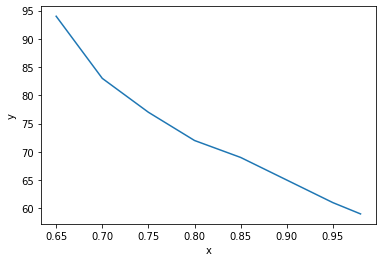

In [ ]:
import seaborn as sns
ax = sns.lineplot(x="x", y="y",data=plot)

## community tracking with graph!

In [ ]:
n=[]
for i in transactions:
    m=[]
    for j in transactions:
        p = set(i)&set(j)
        if len(i)<len(j):
            l=len(i)
        else:
            l=len(j)
        m.append(len(p)/l)
    n.append(m)
n = np.asarray(n)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G  =  nx.from_numpy_matrix(n)



In [ ]:
G.edges.data('weight')

EdgeDataView([(0, 0, 1.0), (0, 1, 0.08333333333333333), (0, 19, 0.041666666666666664), (0, 41, 1.0), (0, 42, 0.08333333333333333), (0, 60, 0.041666666666666664), (0, 83, 1.0), (0, 84, 0.08333333333333333), (0, 104, 0.041666666666666664), (0, 129, 1.0), (0, 130, 0.08333333333333333), (0, 150, 0.041666666666666664), (0, 174, 1.0), (0, 175, 0.08333333333333333), (0, 197, 0.041666666666666664), (0, 228, 1.0), (0, 229, 0.08333333333333333), (0, 251, 0.041666666666666664), (0, 284, 1.0), (0, 285, 0.08333333333333333), (0, 308, 0.041666666666666664), (0, 343, 1.0), (0, 344, 0.08333333333333333), (0, 368, 0.041666666666666664), (0, 369, 0.041666666666666664), (1, 1, 1.0), (1, 41, 0.08333333333333333), (1, 42, 1.0), (1, 83, 0.08333333333333333), (1, 84, 1.0), (1, 129, 0.08333333333333333), (1, 130, 1.0), (1, 174, 0.08333333333333333), (1, 175, 1.0), (1, 228, 0.08333333333333333), (1, 229, 1.0), (1, 284, 0.08333333333333333), (1, 285, 1.0), (1, 343, 0.08333333333333333), (1, 344, 1.0), (2, 2, 1.

In [ ]:
plt.figure(num=None, figsize=(80, 80), dpi=80)
options = {
    'node_color': 'red',
    'node_size': 50,
    'line_color': 'black',
    'linewidths': 20,
    'width': 2,
}
nx.draw(G, **options)
plt.show()

In [ ]:
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})

communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The network has {len(communities)} communities.")
print(f"The performance of a partition is the ratio of the number of intra-community edges \nplus inter-community non-edges with the total number of potential edges. \n that is {networkx.algorithms.community.quality.performance(G, communities)} in here")


The network has 93 communities.
The performance of a partition is the ratio of the number of intra-community edges 
plus inter-community non-edges with the total number of potential edges. 
 that is 0.8856091749688283 in here


In [ ]:
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
%matplotlib inline


result = nxcom.girvan_newman(G)
communities = next(result)
print(f"The network has {len(communities)} communities.")
networkx.algorithms.community.quality.performance(G, communities)
print(f"The performance of a partition is the ratio of the number of intra-community edges \nplus inter-community non-edges with the total number of potential edges. \n that is {networkx.algorithms.community.quality.performance(G, communities)} in here")


In [ ]:
import networkx

networkx.algorithms.community.quality.performance(G, communities)

0.9158302778909423

In [ ]:
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The network has {len(communities)} communities.")

In [ ]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)            

In [ ]:
G_social = G
pos = nx.spring_layout(G_social, k=0.1)

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (80, 80) , 'figure.dpi': 80})
plt.style.use('dark_background')

# Set node and edge communities
set_node_community(G_social, communities)
set_edge_community(G_social)

# Set community color for internal edges
external = [(v, w) for v, w in G_social.edges if G_social.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G_social.edges if G_social.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]
node_color = [get_color(G_social.nodes[v]['community']) for v in G_social.nodes]
# external edges
nx.draw_networkx(
    G_social, 
    pos=pos, 
    node_size=50, 
    edgelist=external, 
    edge_color="silver",
    node_color=node_color,
    alpha=1, 
    width =2,
    with_labels=False)
# internal edges
nx.draw_networkx(
    G_social,
    pos=pos, 
    edgelist=internal, 
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.25, 
    node_size=50,
    width = 2,
    with_labels=False)

# data analysis (Communities in time)

## load and get ready for analysis

In [ ]:
!pip install dynetx
import pandas as pd

In [ ]:
# load data for communities
import pandas as pd

c1 = pd.read_csv('/content/communities_1.csv')
c1 = c1.drop(columns=['id'])
# c1 = c1.drop(columns=['r'])
# c1 = c1.set_index('label')
c1['timestep'] = [1]*len(c1['density'])

c2 = pd.read_csv('/content/communities_2.csv')
# c2 = c2.set_index('label')
c2 = c2.drop(columns=['id'])
# c2 = c2.drop(columns=['r'])
c2['timestep'] = [2]*len(c2['density'])

c3 = pd.read_csv('/content/communities_3.csv')
# c3 = c3.set_index('label')
c3 = c3.drop(columns=['id'])
c3['timestep'] = [3]*len(c3['density'])
# c3 = c3.drop(columns=['r'])


c4 = pd.read_csv('/content/communities_4.csv')
# c4 = c4.set_index('label')
c4 = c4.drop(columns=['id'])
c4['timestep'] = [4]*len(c4['density'])
# c4 = c4.drop(columns=['r'])

c5 = pd.read_csv('/content/communities_5.csv')
# c5 = c5.set_index('label')
c5 = c5.drop(columns=['id'])
c5['timestep'] = [5]*len(c5['density'])
# c5 = c5.drop(columns=['r'])

c6 = pd.read_csv('/content/communities_6.csv')
# c6 = c6.set_index('label')
c6 = c6.drop(columns=['id'])
c6['timestep'] = [6]*len(c6['density'])
# c6 = c6.drop(columns=['r'])

c7 = pd.read_csv('/content/communities_7.csv')
# c7 = c7.set_index('label')
c7 = c7.drop(columns=['id'])
c7['timestep'] = [7]*len(c7['density'])
# c7 = c7.drop(columns=['r'])

c8 = pd.read_csv('/content/communities_8.csv')
# c8 = c8.set_index('label')
c8 = c8.drop(columns=['id'])
c8['timestep'] = [8]*len(c8['density'])
# c8 = c8.drop(columns=['r'])


In [ ]:
# all community datasets in all time
c=pd.DataFrame()
c=c.append(c1)
c=c.append(c2)
c=c.append(c3)
c=c.append(c4)
c=c.append(c5)
c=c.append(c6)
c=c.append(c7)
c=c.append(c8)
df = c
c = 0

In [ ]:
# load data for drivers
import pandas as pd
c1 = pd.read_csv('/content/Drivers_1.csv')
# c1 = c1.drop(columns=['id'])
# c1 = c1.set_index('label')
c1['timestep'] = [1]*len(c1['degree'])

c2 = pd.read_csv('/content/Drivers_2.csv')
# c2 = c2.set_index('label')
# c2 = c2.drop(columns=['id'])
c2['timestep'] = [2]*len(c2['degree'])

c3 = pd.read_csv('/content/Drivers_3.csv')
# c3 = c3.set_index('label')
# c3 = c3.drop(columns=['id'])
c3['timestep'] = [3]*len(c3['degree'])


c4 = pd.read_csv('/content/Drivers_4.csv')
# c4 = c4.set_index('label')
# c4 = c4.drop(columns=['id'])
c4['timestep'] = [4]*len(c4['degree'])

c5 = pd.read_csv('/content/Drivers_5.csv')
# c5 = c5.set_index('label')
# c5 = c5.drop(columns=['id'])
c5['timestep'] = [5]*len(c5['degree'])

c6 = pd.read_csv('/content/Drivers_6.csv')
# c6 = c6.set_index('label')
# c6 = c6.drop(columns=['id'])
c6['timestep'] = [6]*len(c6['degree'])

c7 = pd.read_csv('/content/Drivers_7.csv')
# c7 = c7.set_index('label')
# c7 = c7.drop(columns=['id'])
c7['timestep'] = [7]*len(c7['degree'])

c8 = pd.read_csv('/content/Drivers_8.csv')
# c8 = c8.set_index('label')
# c8 = c8.drop(columns=['id'])
c8['timestep'] = [8]*len(c8['degree'])



In [ ]:

# all community datasets in all time
c=pd.DataFrame()
c=c.append(c1)
c=c.append(c2)
c=c.append(c3)
c=c.append(c4)
c=c.append(c5)
c=c.append(c6)
c=c.append(c7)
c=c.append(c8)
dff = c
c=0

In [ ]:
a=[]
for i in dff['community'].values:
    if i[1:-1] == '':
        a.append([])
    else:
        a.append(i[1:-1].split(','))
dff['heart'] = [(len(x)) for x in a]

In [ ]:
#angels and deamons dataset

 
adv = []


for i in range(len(dff['id'])):
    try:
        if dff.iloc[i]['role']=='v' and dff.iloc[i+1862]['role'] =='f':
            adv.append('deamon')
        if dff.iloc[i]['role']=='f' and dff.iloc[i+1862]['role'] =='v' :
            adv.append('angel')
        if dff.iloc[i]['role']=='v' and dff.iloc[i+1862]['role'] =='v':
            adv.append('v')
        if dff.iloc[i]['role']=='f' and dff.iloc[i+1862]['role'] =='f':
            adv.append('f')
        if dff.iloc[i]['role']=='0' and dff.iloc[i+1862]['role'] =='0':
            adv.append('lone')
        
    except:
        adv.append(dff.iloc[i]['role'])

dff['adv'] = [x for x in adv]


In [ ]:
#diffusive and infusive dataset
dif = []

for i in range(len(dff['id'])):
    try:
        if dff.iloc[i]['role']=='v' and dff.iloc[i+1862]['role'] =='f'  and dff.iloc[i]['diff_to_vol']-dff.iloc[i+1862]['diff_to_vol']>= 0.1 :
            dif.append('falling deamon')
        if dff.iloc[i]['role']=='v' and dff.iloc[i+1862]['role'] =='f'  and dff.iloc[i]['diff_to_vol']-dff.iloc[i+1862]['diff_to_vol']<0.1 :
            dif.append('deamon')

        if dff.iloc[i]['role']=='f' and dff.iloc[i+1862]['role'] =='v' and dff.iloc[i+1862]['diff_to_vol']-dff.iloc[i]['diff_to_vol']>=0.1 :
            dif.append('rising angel')
        if dff.iloc[i]['role']=='f' and dff.iloc[i+1862]['role'] =='v' and dff.iloc[i+1862]['diff_to_vol']-dff.iloc[i]['diff_to_vol']<0.1 :
            dif.append('angel')

        if dff.iloc[i]['role']=='v' and dff.iloc[i+1862]['role'] =='v'  and dff.iloc[i+1862]['diff_to_vol']-dff.iloc[i]['diff_to_vol']>= 0.1 :###########
            dif.append('rising v')
        if dff.iloc[i]['role']=='v' and dff.iloc[i+1862]['role'] =='v'  and dff.iloc[i+1862]['diff_to_vol']-dff.iloc[i]['diff_to_vol']<0.1 :##############
            dif.append('v')

        if dff.iloc[i]['role']=='f' and dff.iloc[i+1862]['role'] =='f' and dff.iloc[i]['diff_to_vol']-dff.iloc[i+1862]['diff_to_vol']>=0.1 :
            dif.append('falling f')
        if dff.iloc[i]['role']=='f' and dff.iloc[i+1862]['role'] =='f' and dff.iloc[i]['diff_to_vol']-dff.iloc[i+1862]['diff_to_vol']<0.1 :
            dif.append('f')

        if dff.iloc[i]['role']=='0' and dff.iloc[i+1862]['role'] =='0' and dff.iloc[i+1862]['diff_to_vol']-dff.iloc[i]['diff_to_vol']>=0.1 : 
            dif.append('rising lone')
        if dff.iloc[i]['role']=='0' and dff.iloc[i+1862]['role'] =='0' and dff.iloc[i+1862]['diff_to_vol']-dff.iloc[i]['diff_to_vol']<0.1 : 
            dif.append('lone')
    except:
        dif.append(dff.iloc[i]['role'])

dff['dif'] = [x for x in dif]


In [ ]:
#mean of variables with cosidering an attribute as seperator

k = []
for i in range(1,9):
    k.append([x for x in dff[dff['timestep']==i].mean()])

ddd=pd.DataFrame(k,columns =['an','anan','degree','dc' , 'bc','cc','ec','diff','dis','timestep', 'heart'])
ddd = ddd.drop(columns=['an','anan'])


cc= []


#-----------------------OR------------------------for ommunities
k = []
for i in df['label'].unique():
    k.append([x for x in df[df['label']==i].mean()])
ddd=pd.DataFrame(k,columns =['1','numFol','numVol','diameter','density','degCen','AVEbetCen','cloCen','AVEeigClo','boundary','moshtarak','triangles','cliques','aveSP','aveDis','aveDiff','label','timestep'])
ddd = ddd.drop(columns=['1'])
# cc= []
#---------------------------------------------------
k = []
for i in range(1,9):
    k.append([x for x in df[df['timestep']==i].mean()])
ddd=pd.DataFrame(k,columns =['1','numFol','numVol','diameter','density','degCen','AVEbetCen','cloCen','AVEeigClo','boundary','moshtarak','triangles','cliques','aveSP','aveDis','aveDiff','label','timestep'])
ddd = ddd.drop(columns=['1'])
# cc= []

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


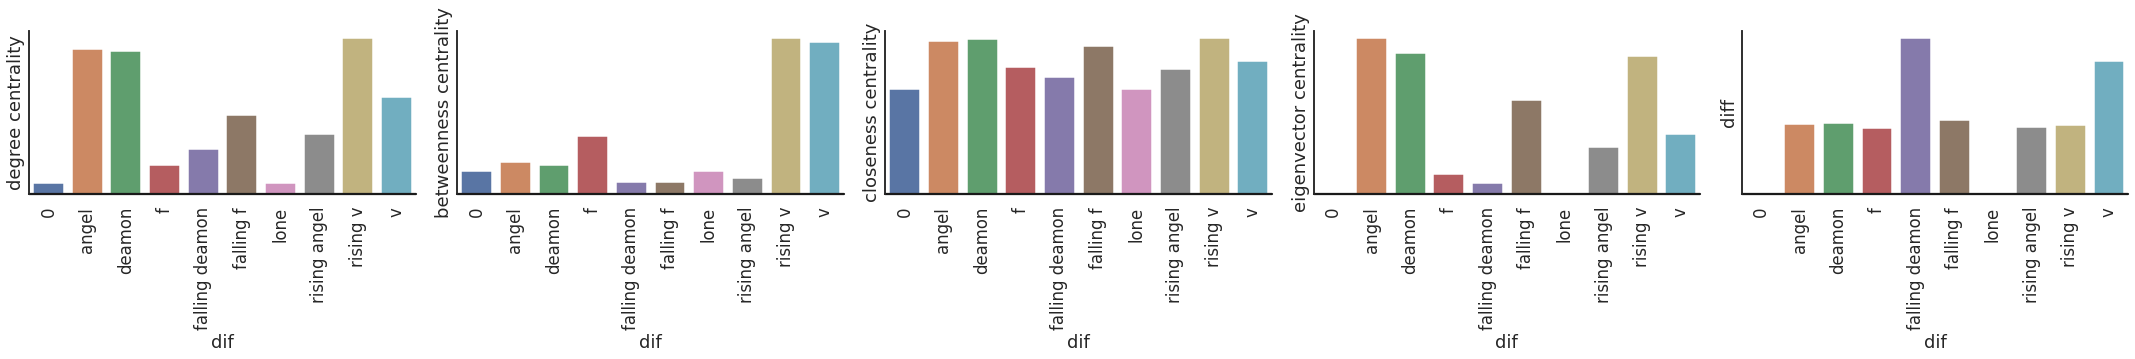

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

aa = dff.groupby(['dif']).mean()

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 5), sharex=True)

g=sns.barplot(x=aa.index, y=aa.degree_centrality.values, palette="deep", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("degree centrality")
g.set_xticklabels(g.get_xticklabels(), rotation=90)


h=sns.barplot(x=aa.index, y=aa.betweenness_centrality.values, palette="deep", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("betweenness centrality")
h.set_xticklabels(g.get_xticklabels(), rotation=90)


i=sns.barplot(x=aa.index, y=aa.closeness_centrality.values, palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("closeness centrality")
i.set_xticklabels(g.get_xticklabels(), rotation=90)


j=sns.barplot(x=aa.index, y=aa.eig_centrality.values, palette="deep", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("eigenvector centrality")
j.set_xticklabels(g.get_xticklabels(), rotation=90)


k=sns.barplot(x=aa.index, y=aa.diff_to_vol.values, palette="deep", ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_ylabel("diff")
k.set_xticklabels(g.get_xticklabels(), rotation=90)

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)


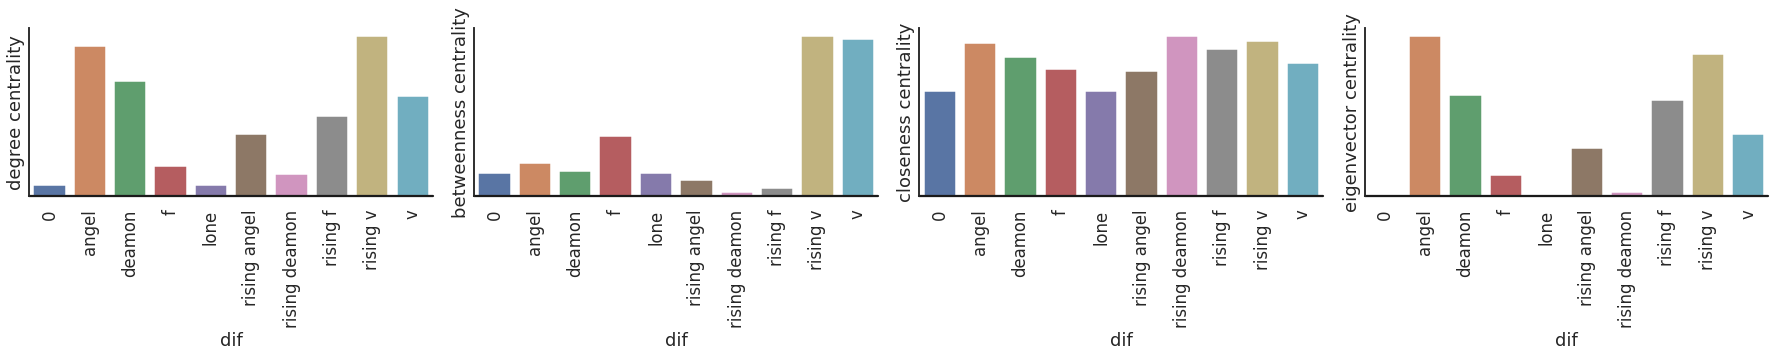

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

aa = dff.groupby(['dif']).mean()

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5), sharex=True)


g=sns.barplot(x=aa.index, y=aa.degree_centrality.values, palette="deep", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("degree centrality")
g.set_xticklabels(g.get_xticklabels(), rotation=90)


h=sns.barplot(x=aa.index, y=aa.betweenness_centrality.values, palette="deep", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("betweenness centrality")
h.set_xticklabels(g.get_xticklabels(), rotation=90)


i=sns.barplot(x=aa.index, y=aa.closeness_centrality.values, palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("closeness centrality")
i.set_xticklabels(g.get_xticklabels(), rotation=90)


j=sns.barplot(x=aa.index, y=aa.eig_centrality.values, palette="deep", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("eigenvector centrality")
j.set_xticklabels(g.get_xticklabels(), rotation=90)


# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)


In [ ]:
dff['diff_to_vol'].unique()

array([0.87496, 1.     , 0.     , 2.     , 0.8    , 0.85326, 0.9    ,
       0.9332 , 0.95708, 0.8889 , 0.896  , 0.90764, 0.96519, 0.8455 ,
       0.8667 , 0.81   , 0.9452 , 0.98993, 0.8666 , 0.8668 , 0.8875 ,
       0.92359, 0.82   , 0.81647, 0.82335, 0.8792 , 0.825  , 0.84444,
       0.84188, 0.82154, 0.9994 , 0.8333 , 0.8143 , 0.89493, 0.8824 ,
       0.8572 , 0.884  , 0.91981, 0.80718, 0.92079, 0.81583, 0.9997 ,
       0.92096, 0.92341, 0.8963 , 0.87   , 0.91559, 0.91475, 0.95015,
       0.82544, 0.99058, 0.95   , 0.8615 , 0.874  , 0.92016, 0.85   ,
       0.9868 , 0.90915, 0.8268 , 0.98   , 0.96201, 0.80896, 0.8714 ,
       0.95314, 0.93333, 0.9497 , 0.98309, 0.89612, 0.94286, 0.83168,
       0.85005, 0.8071 , 0.83314, 0.90213, 0.9668 , 0.842  , 0.92253,
       0.86674, 0.8696 , 0.8132 , 0.9876 , 0.9126 , 0.8158 , 0.90938,
       0.8088 , 0.91458, 0.82862, 0.94975, 0.99308, 0.84978, 0.8868 ,
       0.88058, 0.9334 , 0.89659, 0.8752 , 0.88762, 0.82288, 0.96   ,
       0.92857, 0.91

In [ ]:
for i in range(len(dff['id'])):
    print(dff.iloc[i]['role'])

In [ ]:
(len(dff['id'])/8)

1862.0

Text(0.5, 1.02, 'correlation of measuress in all drivers')

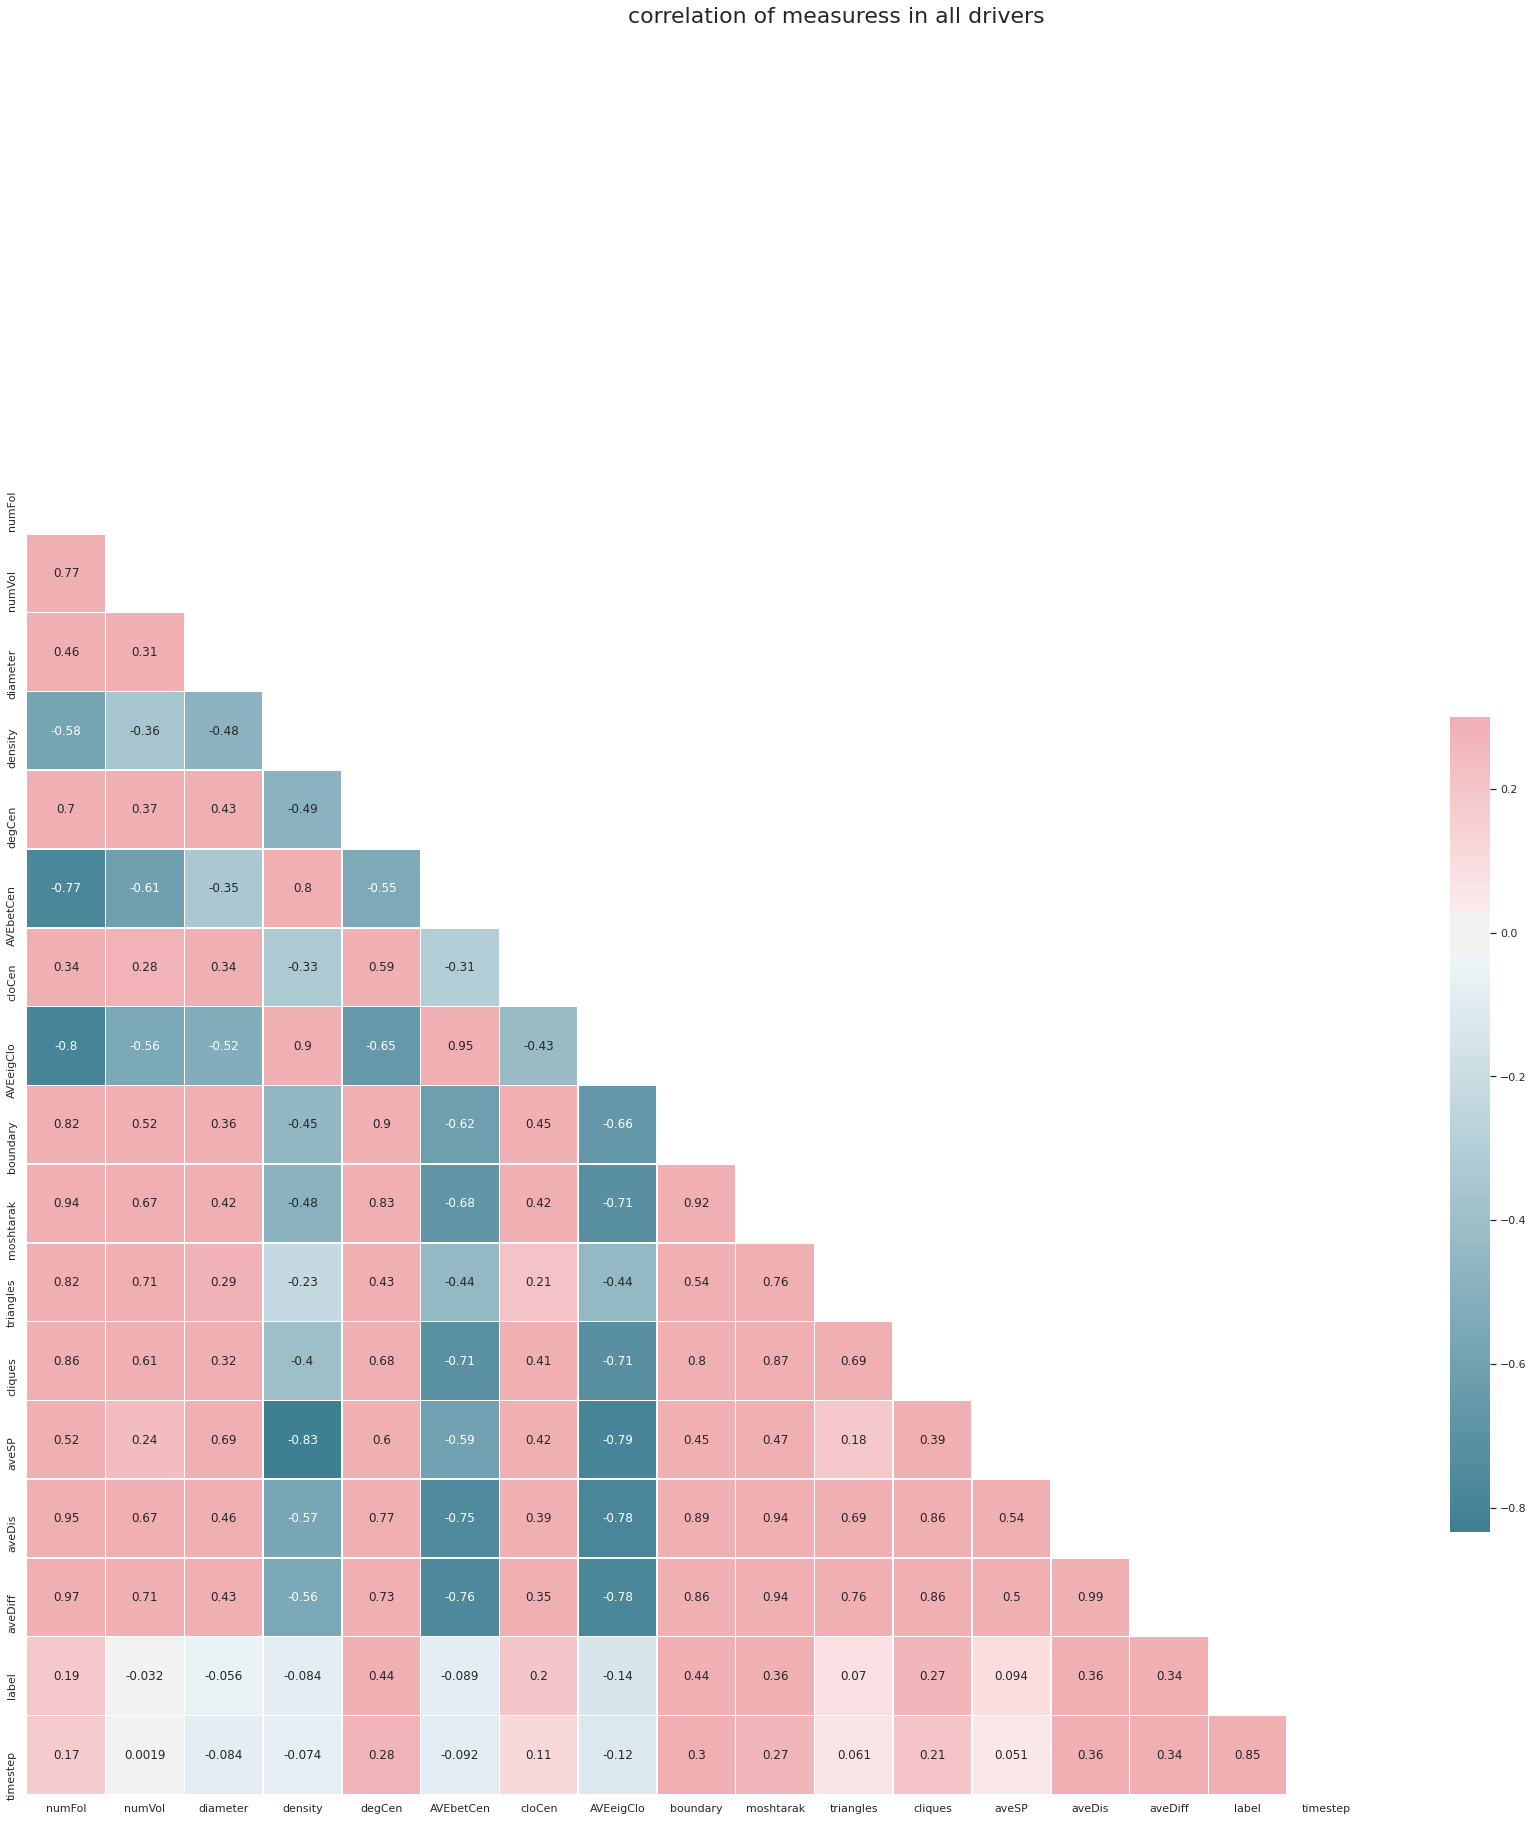

In [ ]:
#select followers and start analysis
# fol = dff[dff['role']=='f']
d = ddd.loc[:,'numFol':'timestep']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, fmt='.2g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.suptitle("correlation of measuress in all drivers", y=1.02, fontsize = 22)

In [ ]:
k = []
for i in range(1,9):
    k.append([x for x in df[df['timestep']==i].mean()])

sss=pd.DataFrame(k,columns =['1','numFol','numVol','diameter','density','degCen','AVEbetCen','cloCen','AVEeigClo','boundary','moshtarak','triangles','cliques','aveSP','aveDis','aveDiff','label','timestep'])
sss = sss.drop(columns=['1'])

# cc= []

In [ ]:
dff 

Unnamed: 0    id  ... timestep heart
0              0     1  ...        1     1
1              1     2  ...        1     1
2              2     3  ...        1     0
3              3     4  ...        1     0
4              4     5  ...        1     1
...          ...   ...  ...      ...   ...
1857        1857  1858  ...        8     0
1858        1858  1859  ...        8    11
1859        1859  1860  ...        8     0
1860        1860  1861  ...        8     1
1861        1861  1862  ...        8     0

[14896 rows x 13 columns]

Text(0.5, 1.02, 'correlation of measuress in all drivers')

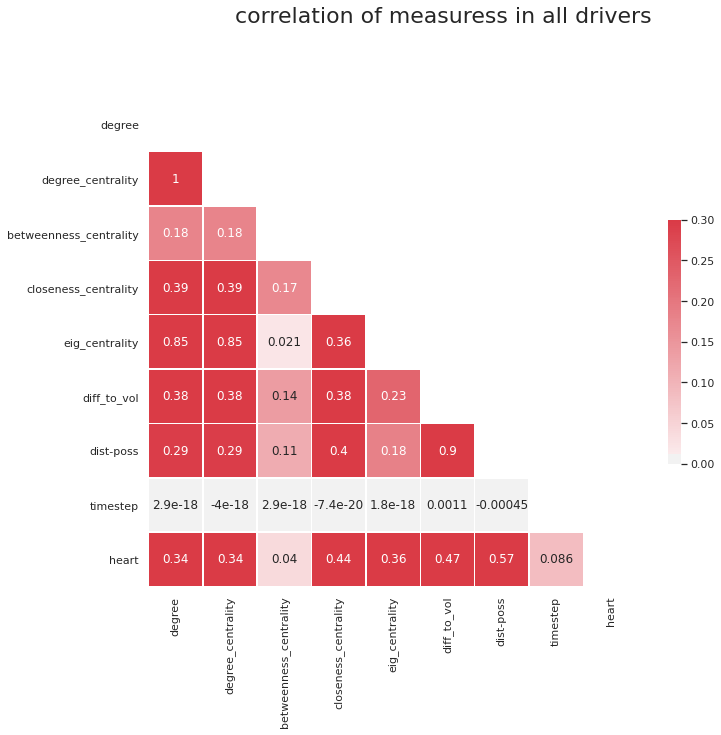

In [ ]:
#select followers and start analysis
# fol = dff[dff['role']=='f']
d = dff.loc[:,'role':'heart']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, fmt='.2g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.suptitle("correlation of measuress in all drivers", y=1.02, fontsize = 22)

<Figure size 4800x2400 with 0 Axes>

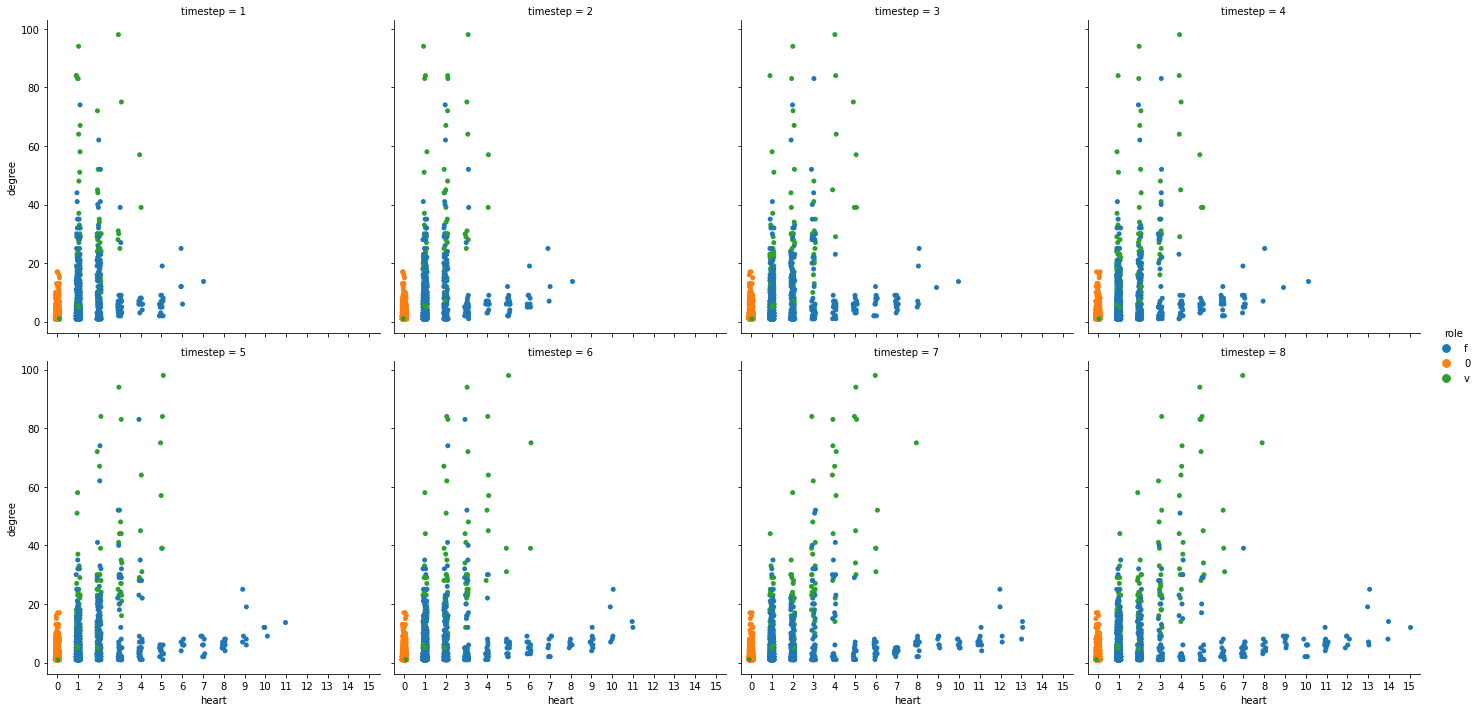

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(32,16),dpi=150)
ax = sns.catplot(x="heart", y="degree",hue="role" ,col='timestep',col_wrap=4,data=dff)
# .set_title('degree for the drivers number of communities belonging in time')
# f.suptitle("distribution of degree for followers and volunteers through time", y=1.02, fontsize = 22)

## drivers analysis:

In [ ]:
dff=dff[dff['role']!='0']

In [ ]:
for i in range(len(dff)):
    if dff['role'].values[i] == 'v':
        dff['dist-poss'].values[i] = 0
        dff['diff_to_vol'].values[i] = 1

In [ ]:
#select followers and start analysis
fol = dff[dff['role']=='f']
d = fol.loc[:,'degree':'dist-poss']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, fmt='.2g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.suptitle("correlation of measuress in all 6046 followers", y=1.02, fontsize = 22)

In [ ]:
plt.figure(figsize=(10,8),dpi=250)
ax = sns.violinplot(x="timestep", y="eig_centrality",hue="role" ,data=dff ,palette="muted").set_title('distribution of eigenvector centrality for followers and volunteers through time')

# f.suptitle("distribution of degree for followers and volunteers through time", y=1.02, fontsize = 22)

In [ ]:
f, ax = plt.subplots(figsize=(10,8),dpi=250)

g= sns.PairGrid(dff.loc[:,'role':'dist-poss'],hue="role",palette="husl")
g = g.map_lower(sns.scatterplot)
title = 'scatter plot of values in attributes'


In [ ]:
#select followers and start analysis
vol = dff[dff['role']=='v']
d = vol.loc[:,'degree':'dist-poss']
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, fmt='.2g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.suptitle("correlation of measuress in all 1434 volunteers", y=1.02, fontsize = 22)

In [ ]:
dff.head(3)

Unnamed: 0  id community  ... diff_to_vol  dist-poss  timestep
0           0   1      [16]  ...     0.87496          1         1
1           1   2      [25]  ...     1.00000          1         1
4           4   5      [32]  ...     1.00000          0         1

[3 rows x 12 columns]

## holistic analysis

In [ ]:
plt.figure(figsize=(80,80),dpi=80)
g = sns.pairplot(df.loc[:,'numFol':'aveDiff'])
# g = g.map_lower(sns.scatterplot)
title = 'scatter plot of values in attributes for communities'
plt.title(title)

In [ ]:
df.head(2)

Unnamed: 0  numFol  numVol  diameter  ...   aveDiff  label  r  timestep
0           0      20       4         4  ...  0.104507      1  1         1
1           1      20      11         3  ...  0.104075      2  2         1

[2 rows x 19 columns]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


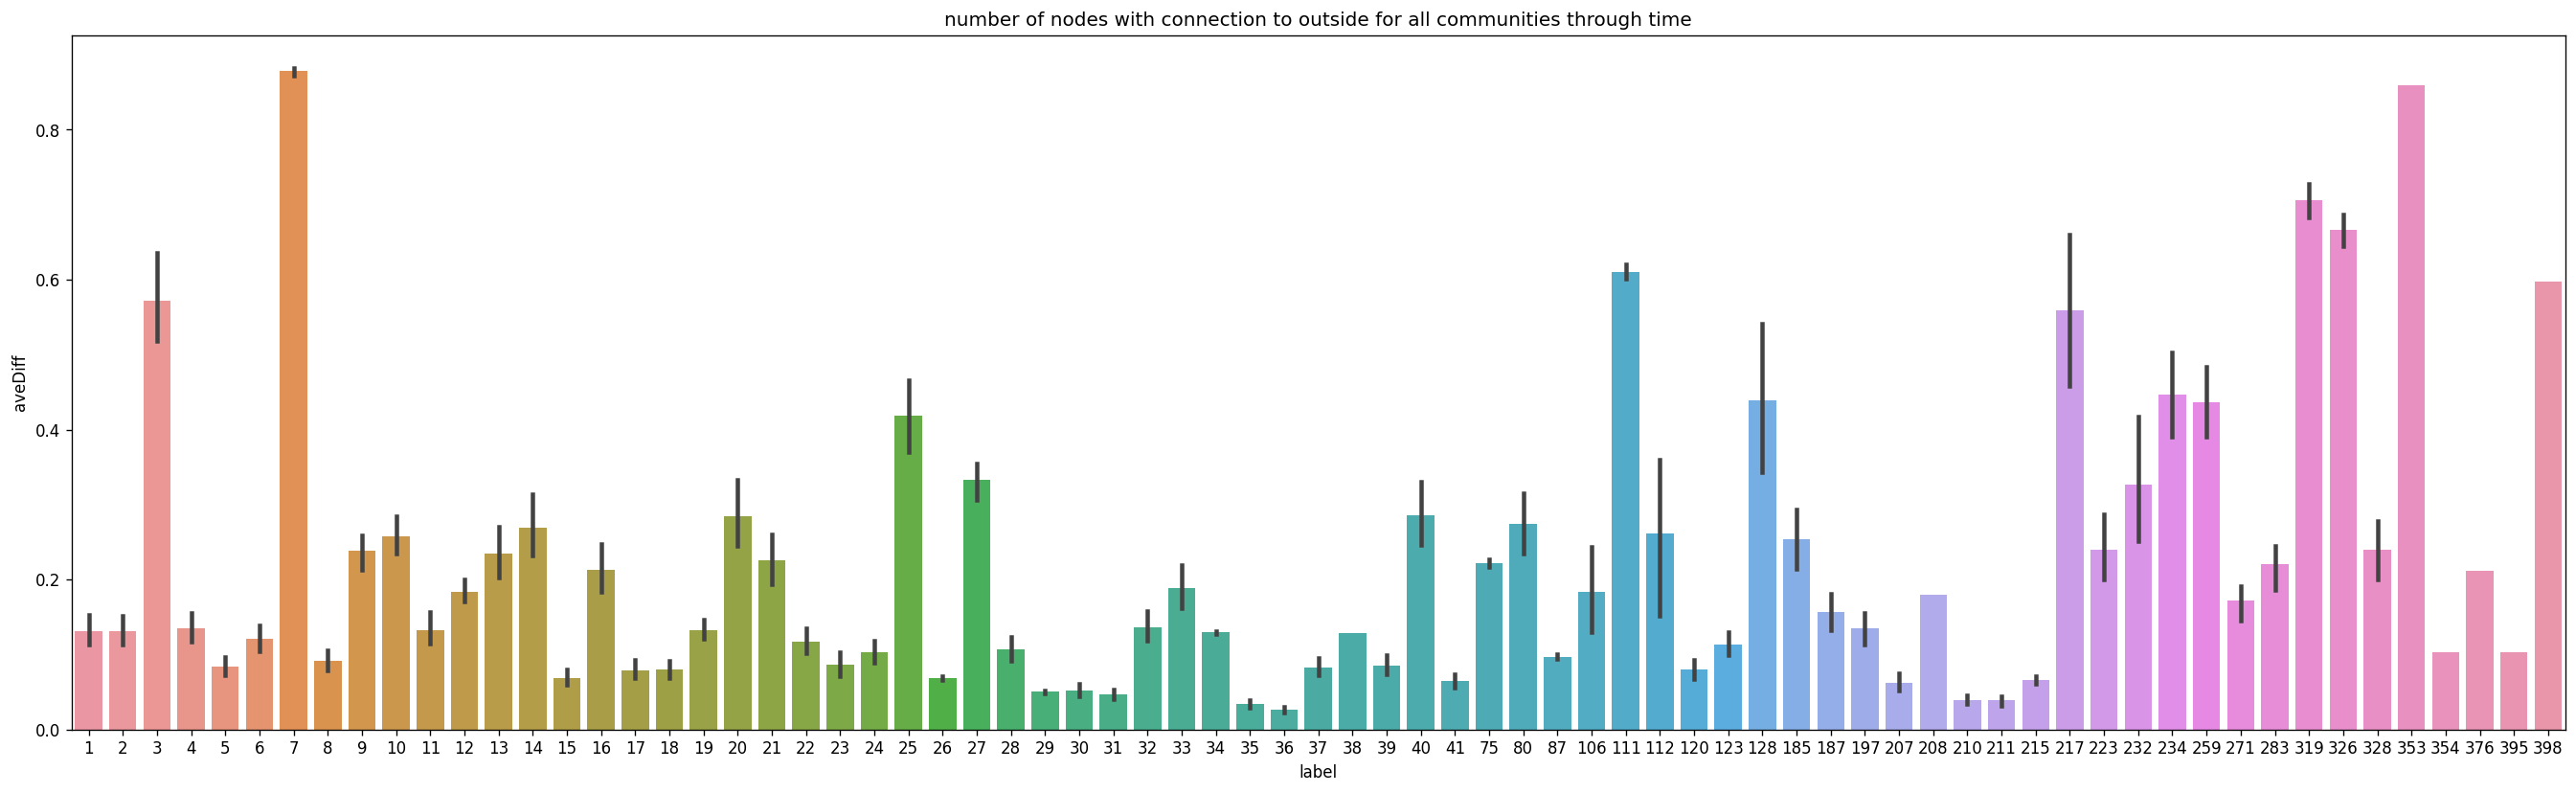

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(28,8),dpi=120)
# ax = sns.violinplot(x="timestep", y="triangles",data=df).set_title('distribution of eigenvector centrality for followers and volunteers through time')
ax = sns.barplot(x="label", y="aveDiff",data=df).set_title('number of nodes with connection to outside for all communities through time')


KeyboardInterrupt: ignored

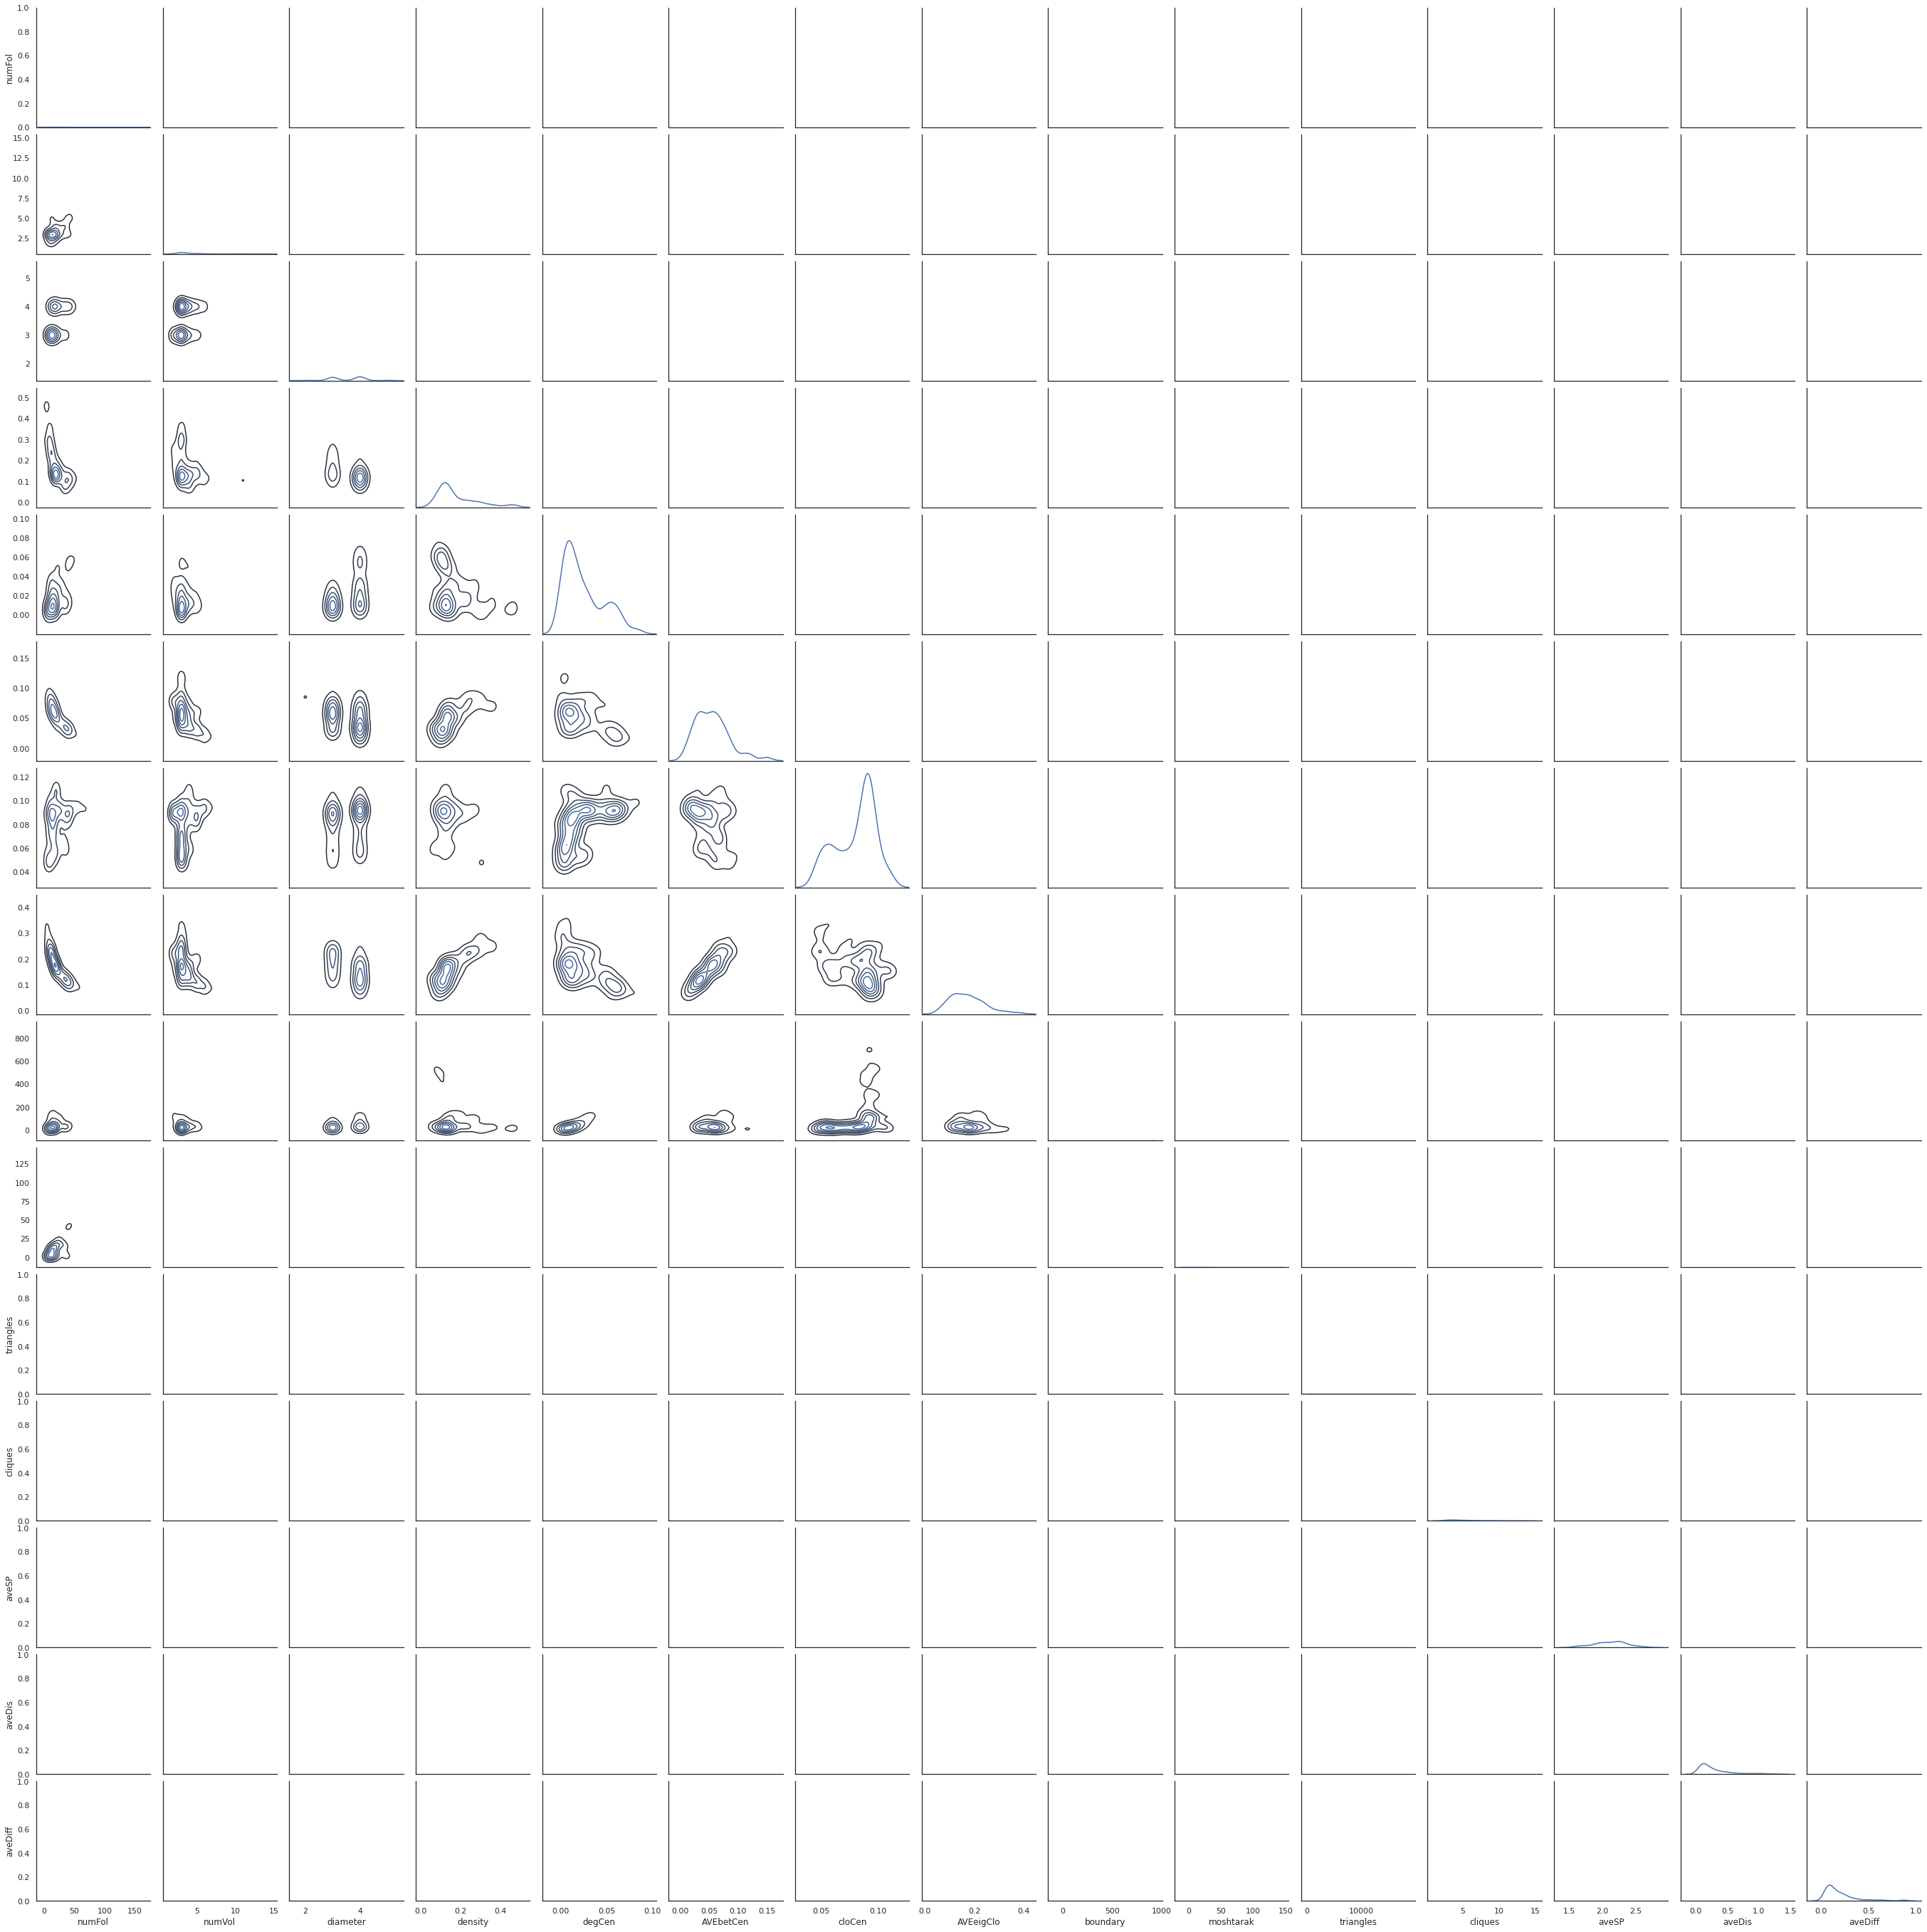

In [ ]:
g = sns.PairGrid(df.loc[:,'numFol':'aveDiff'])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

Text(0.5, 1.02, 'correlation of measuress in all 404 communities')

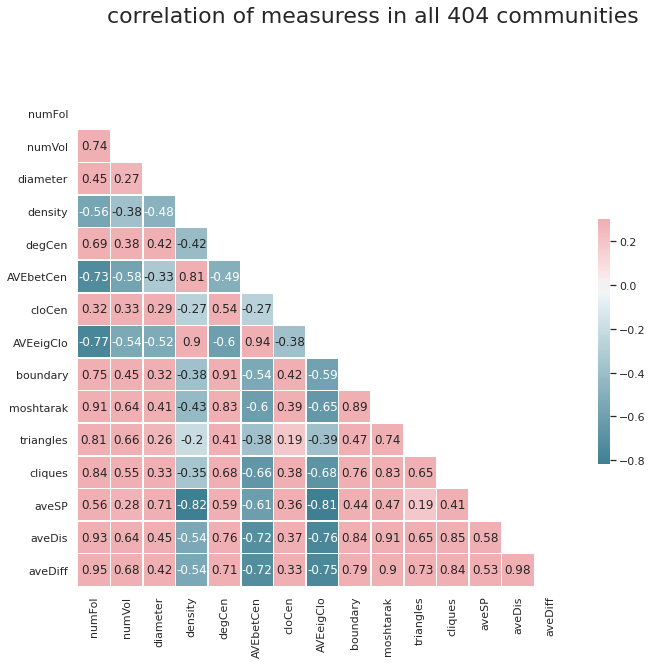

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
#important
d = df.loc[:,'numFol':'aveDiff']
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, fmt='.2g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f.suptitle("correlation of measuress in all 404 communities", y=1.02, fontsize = 22)

## number of followers and volunteers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


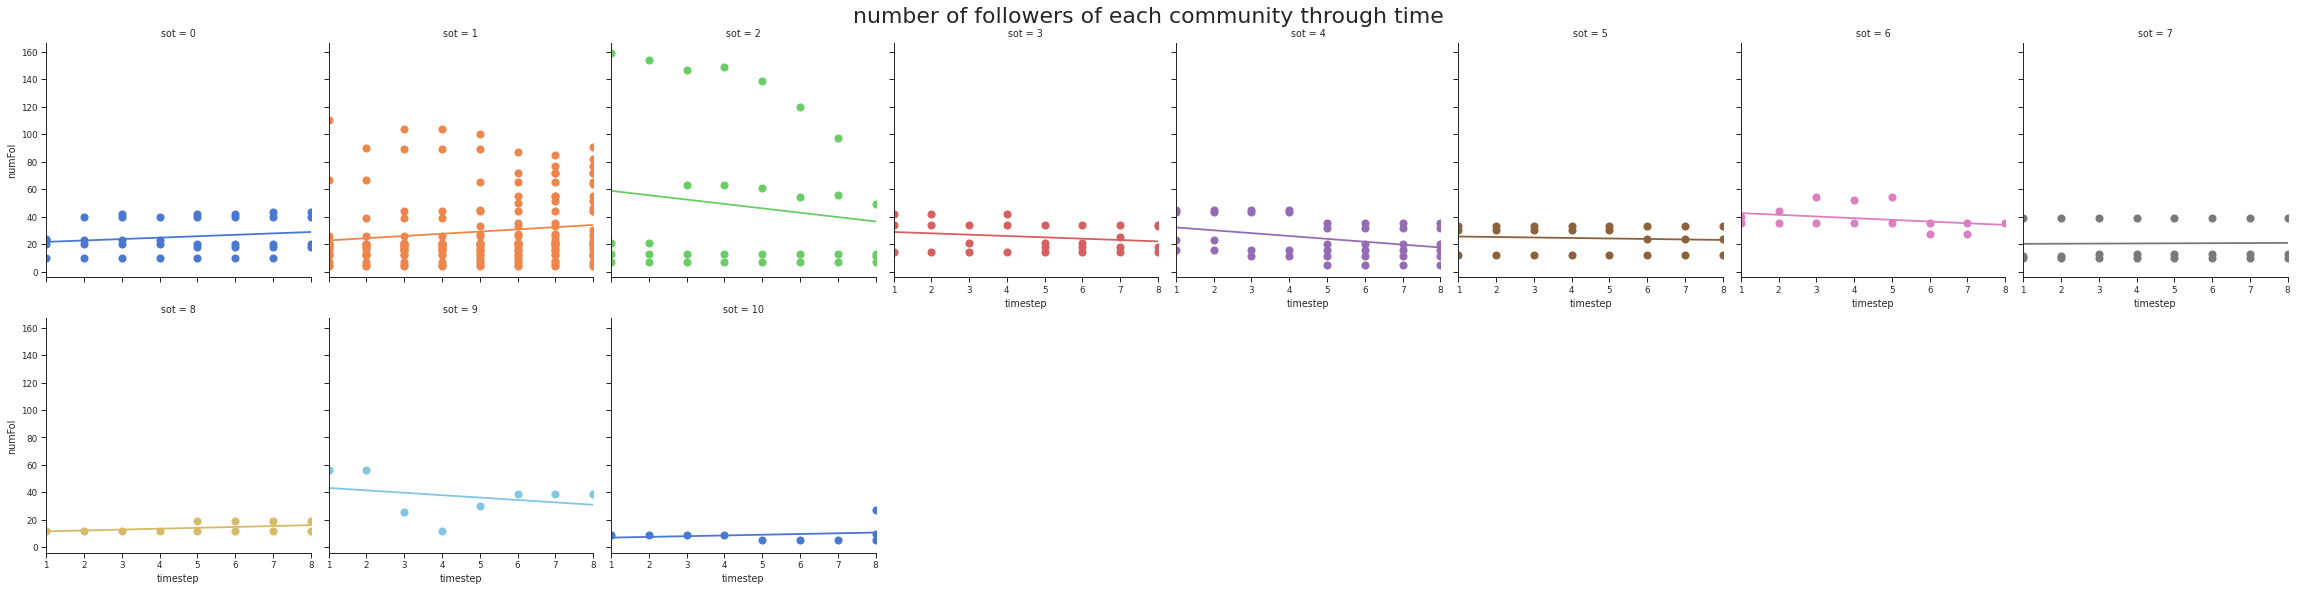

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="numFol", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("number of followers of each community through time", y=1.02, fontsize = 22)
plt.show()


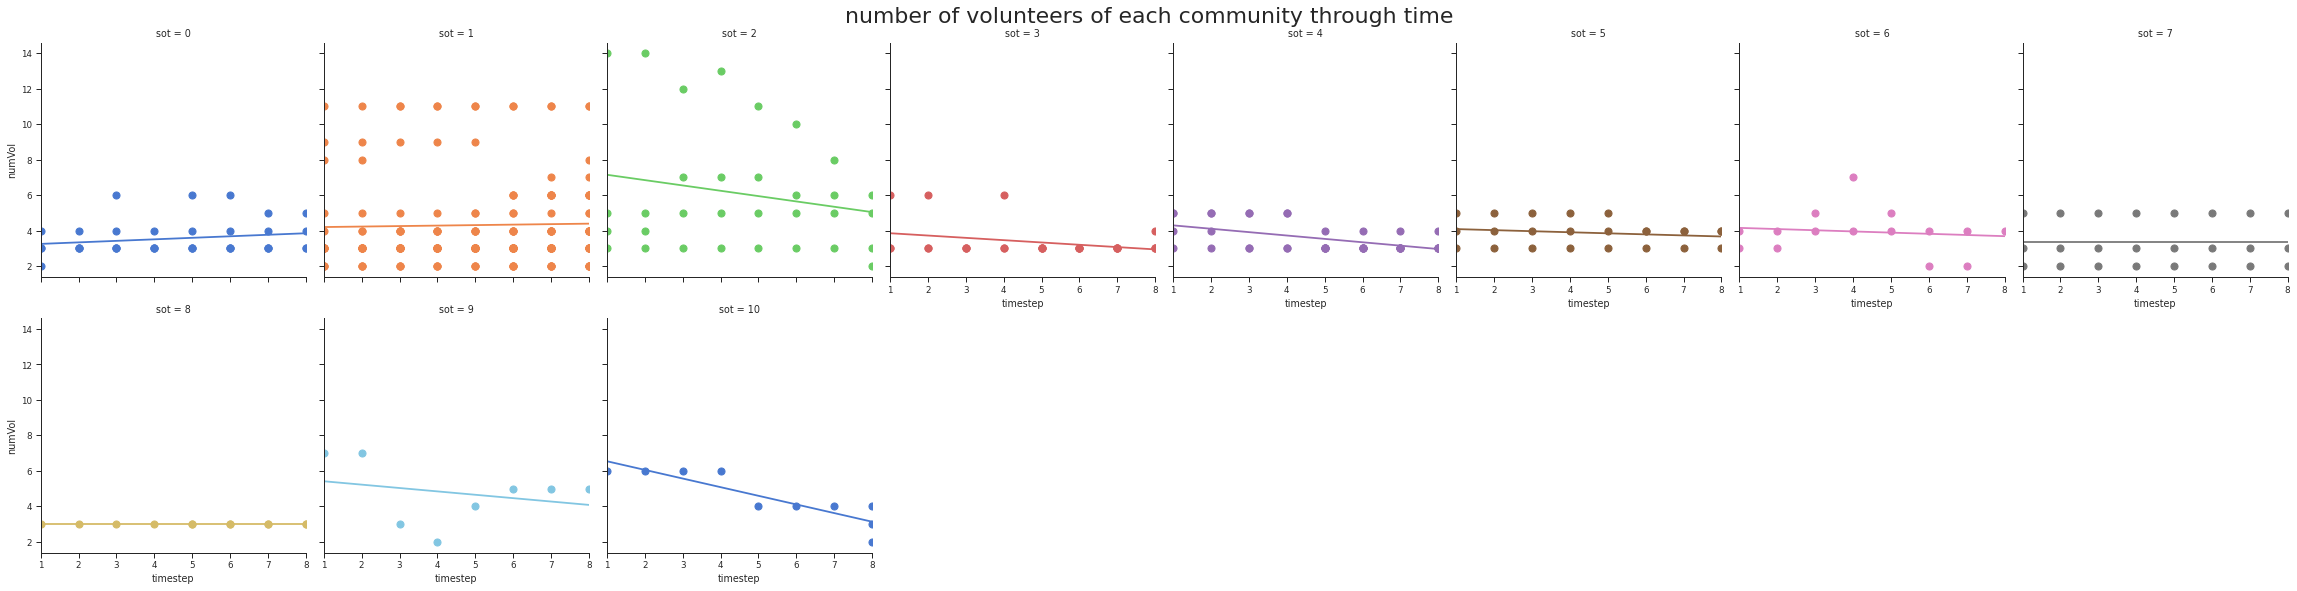

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="numVol", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("number of volunteers of each community through time", y=1.02, fontsize = 22)
plt.show()


## diameter and density

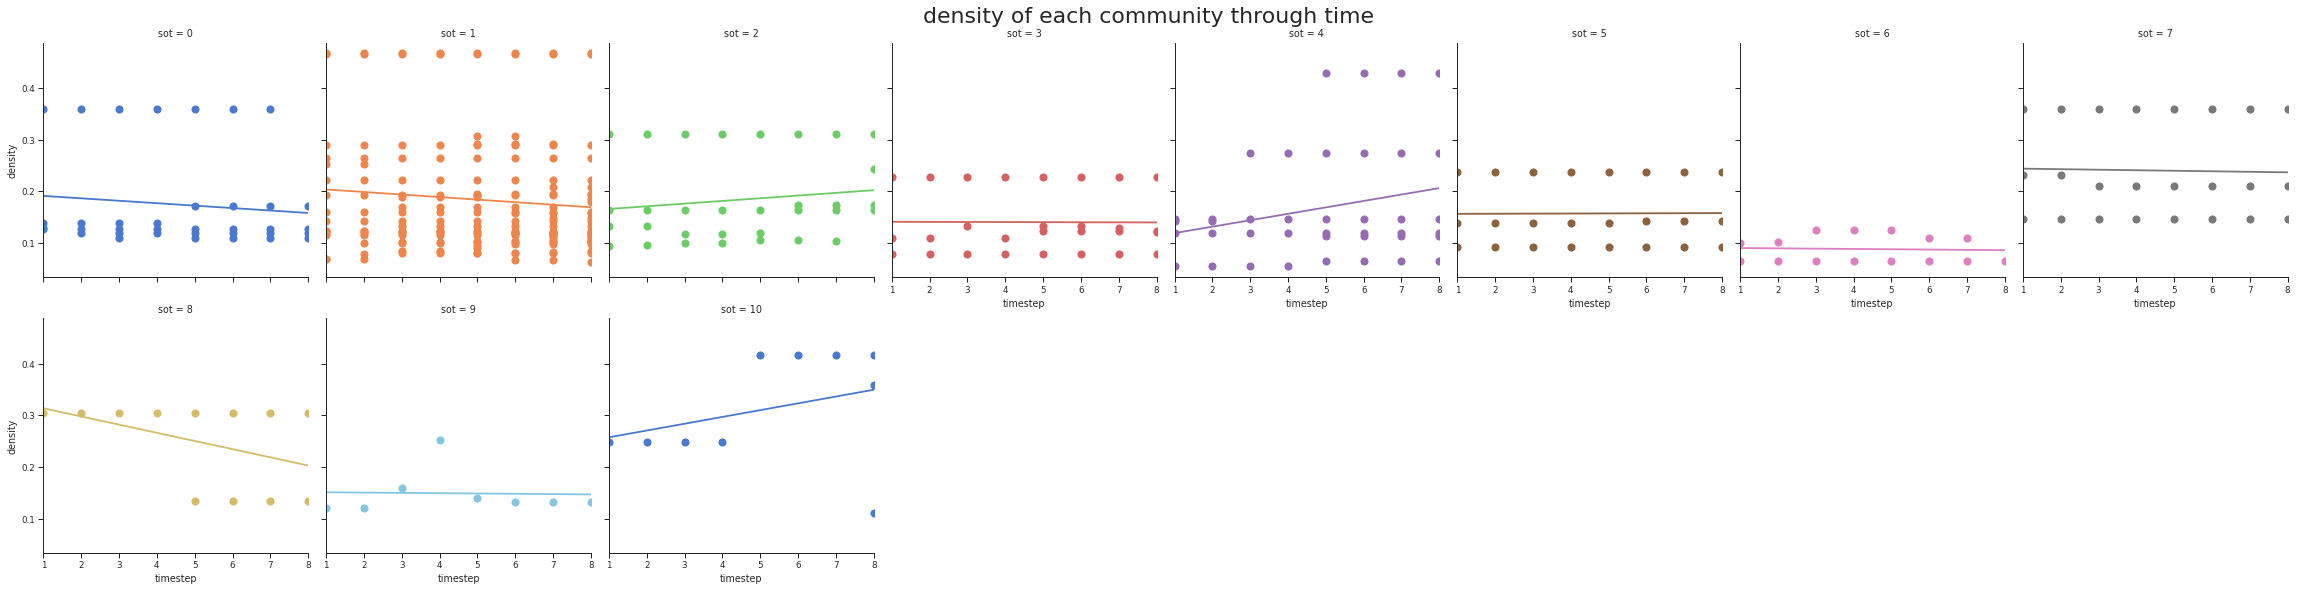

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="density", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("density of each community through time", y=1.02, fontsize = 22)
plt.show()


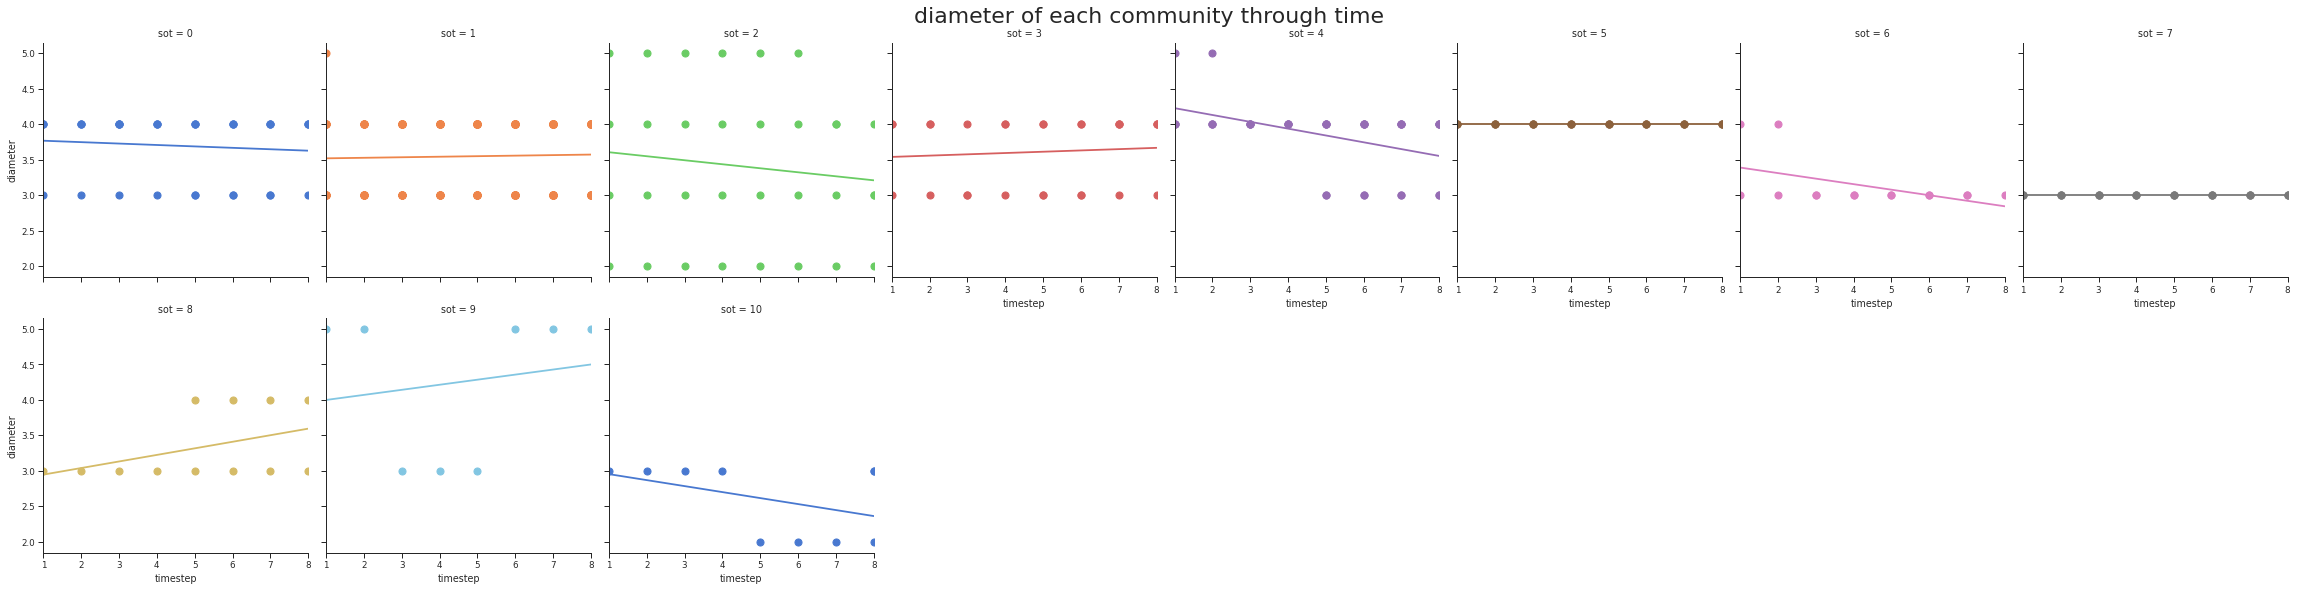

In [ ]:
g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="diameter", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("diameter of each community through time", y=1.02, fontsize = 22)
plt.show()


## centrality through time

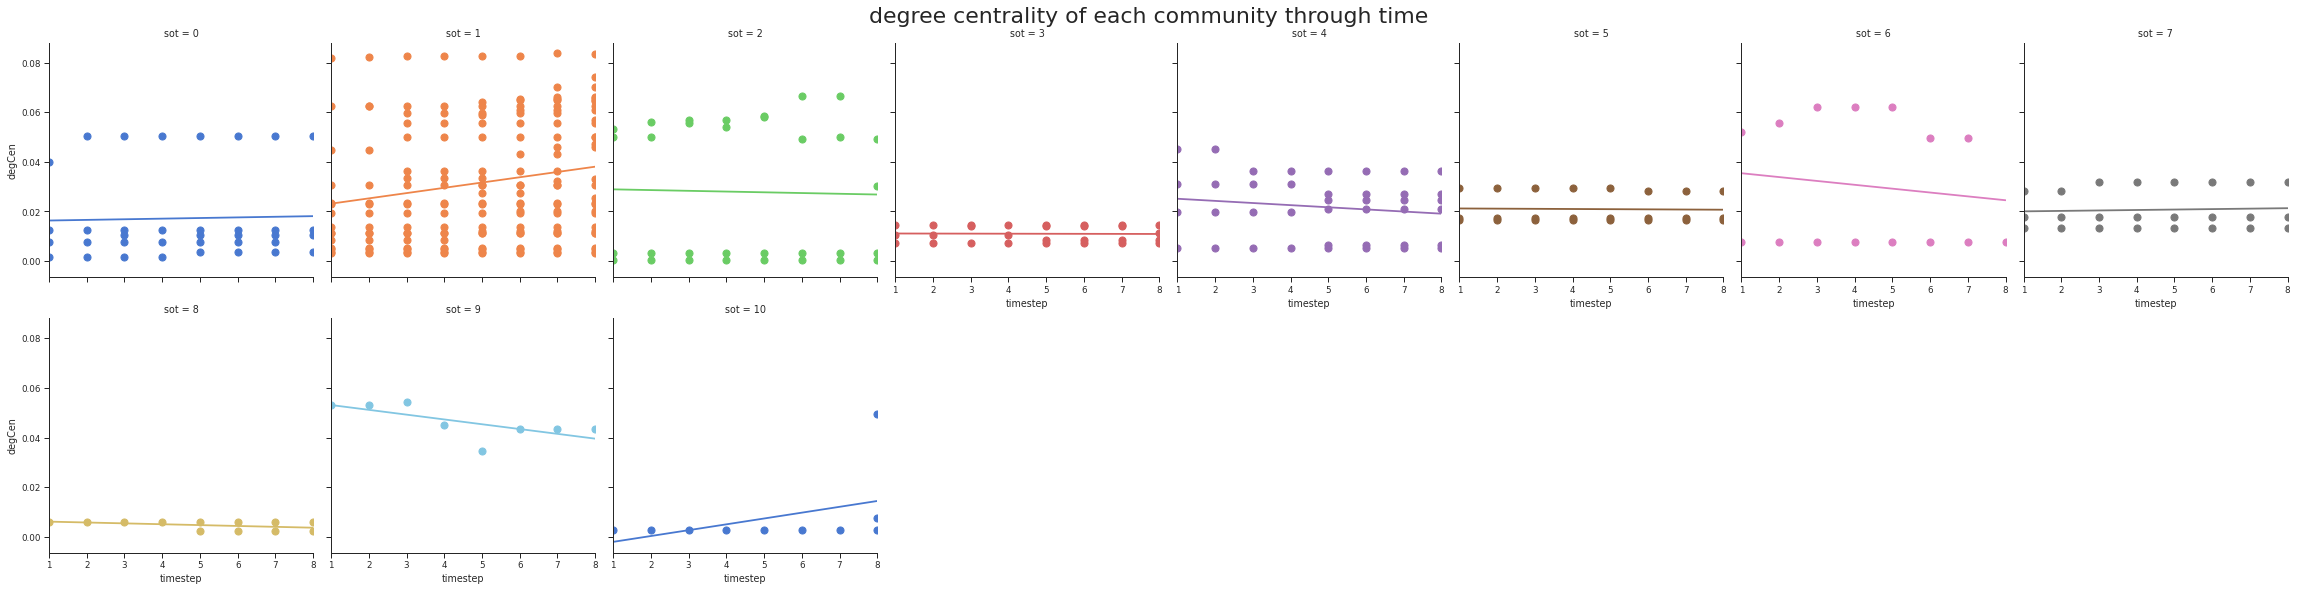

In [ ]:

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="degCen", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("degree centrality of each community through time", y=1.02, fontsize = 22)
plt.show()


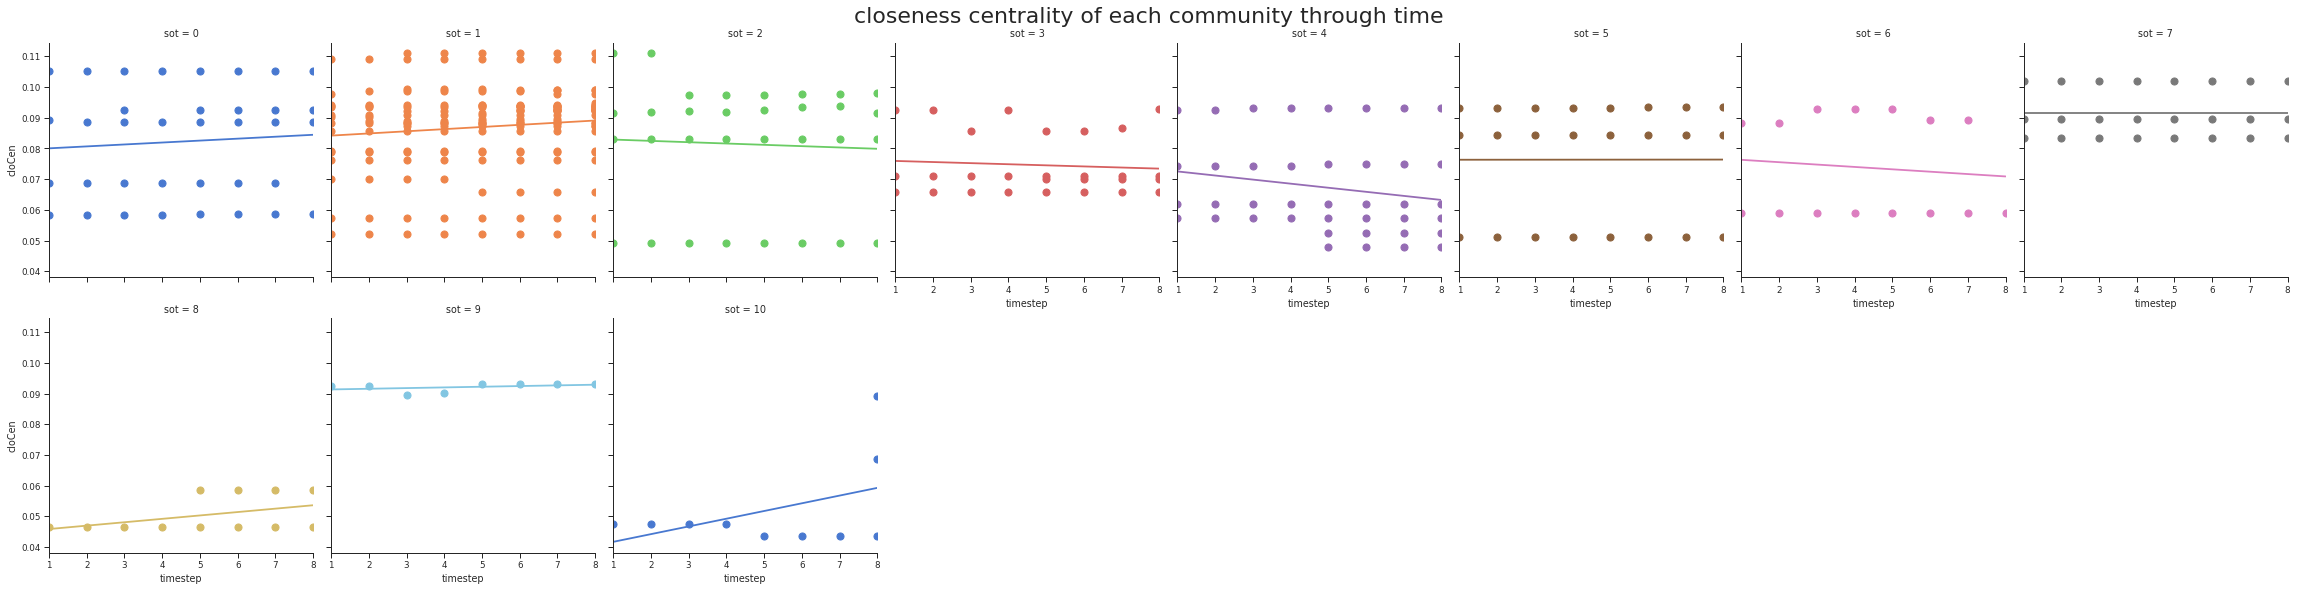

In [ ]:
g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="cloCen", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("closeness centrality of each community through time", y=1.02, fontsize = 22)
plt.show()


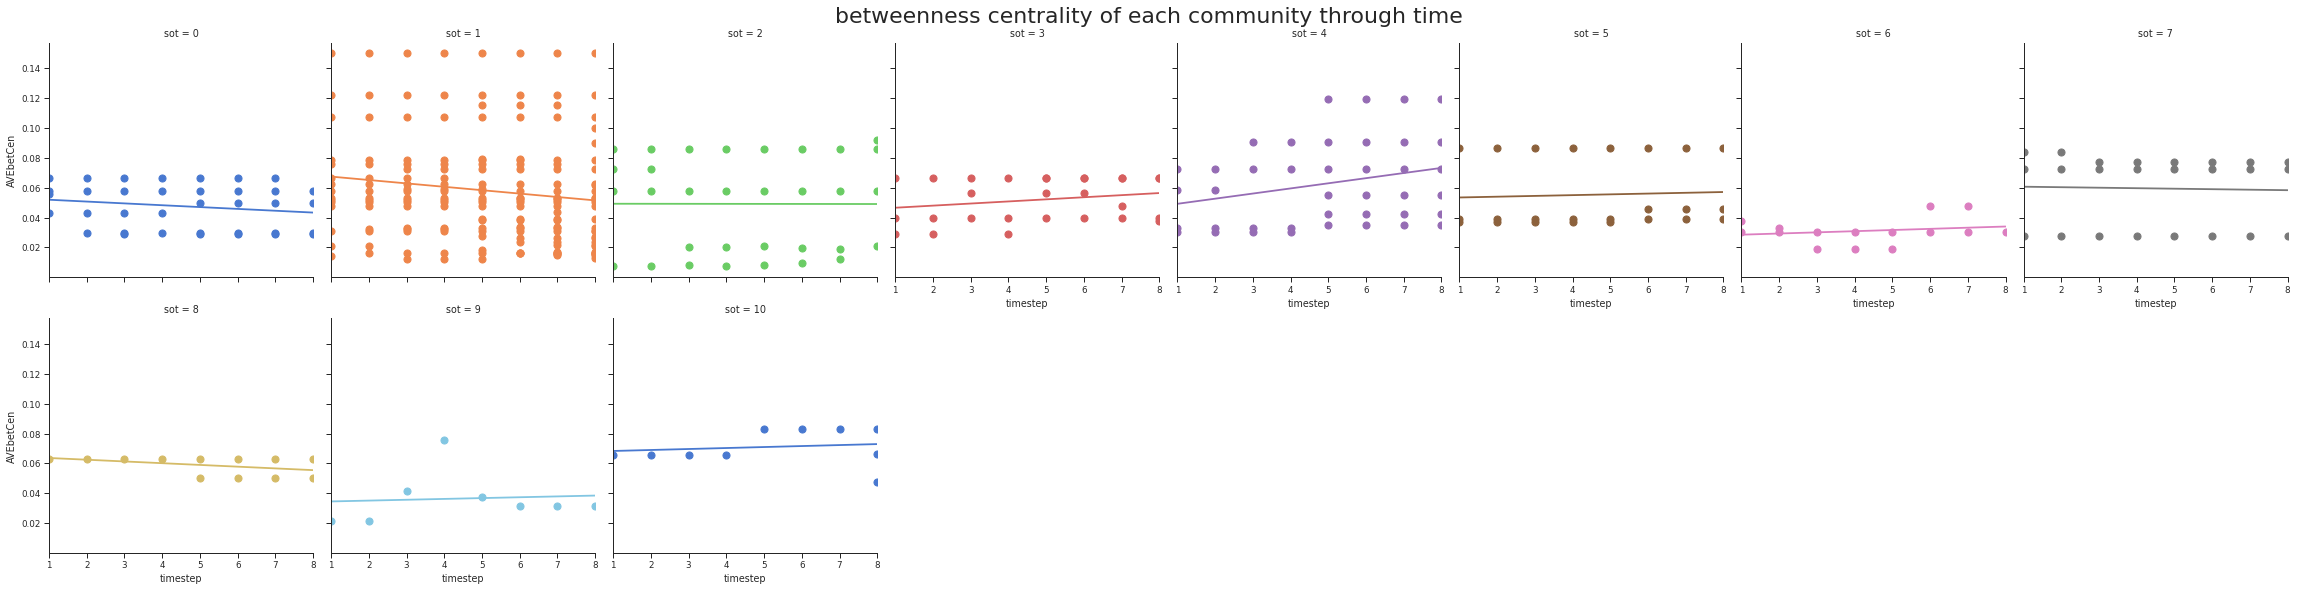

In [ ]:
#betweenness

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="AVEbetCen", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("betweenness centrality of each community through time", y=1.02, fontsize = 22)
plt.show()


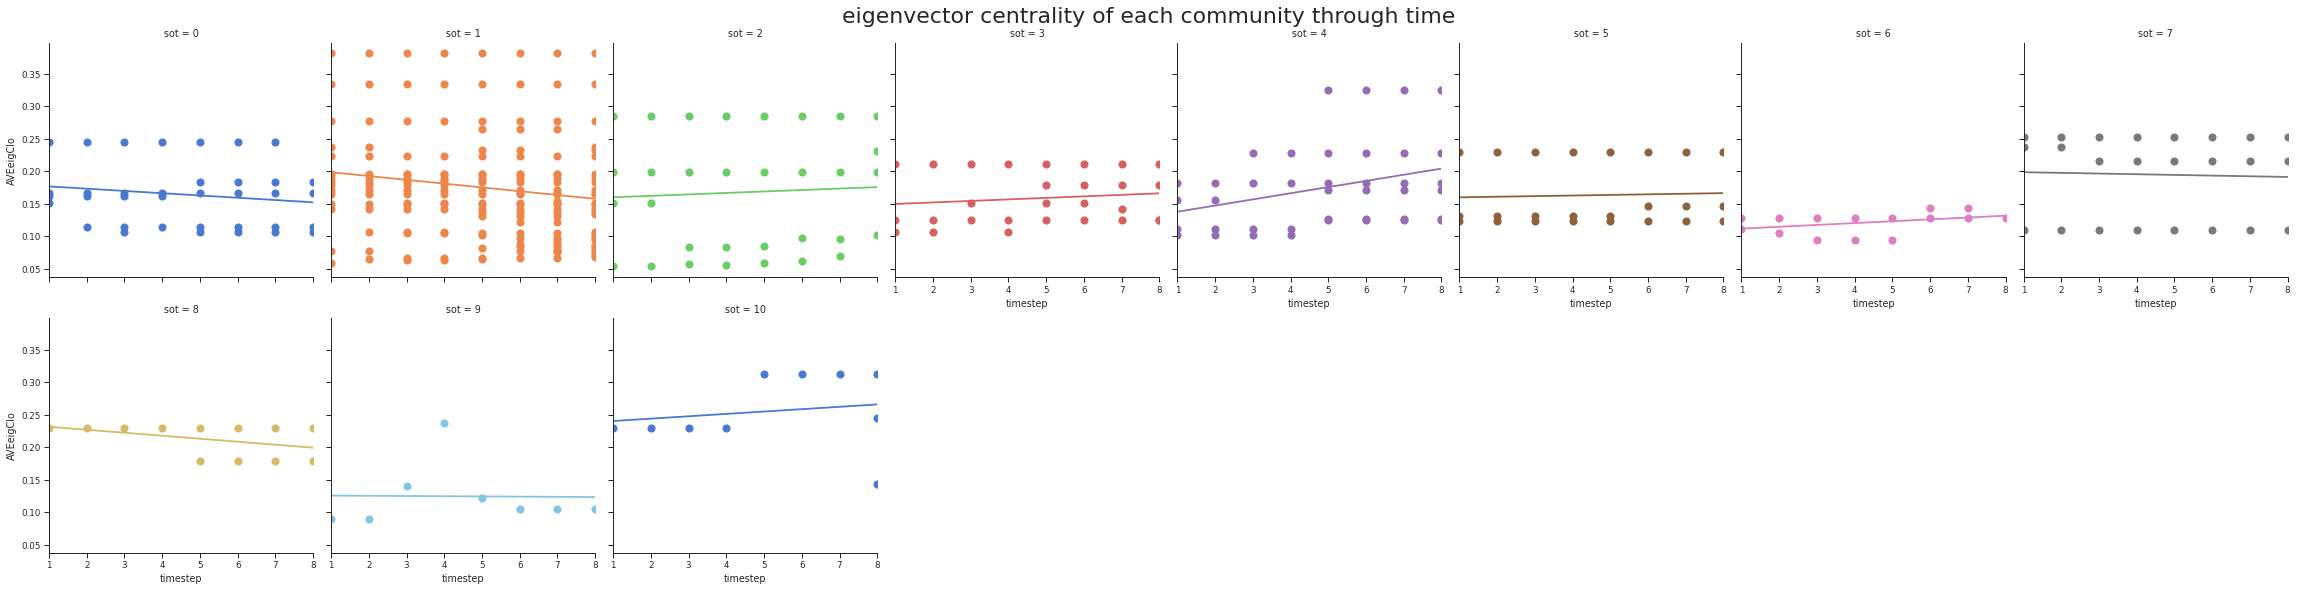

In [ ]:
#eigenvector

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="AVEeigClo", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("eigenvector centrality of each community through time", y=1.02, fontsize = 22)
plt.show()


## cliques and triangles


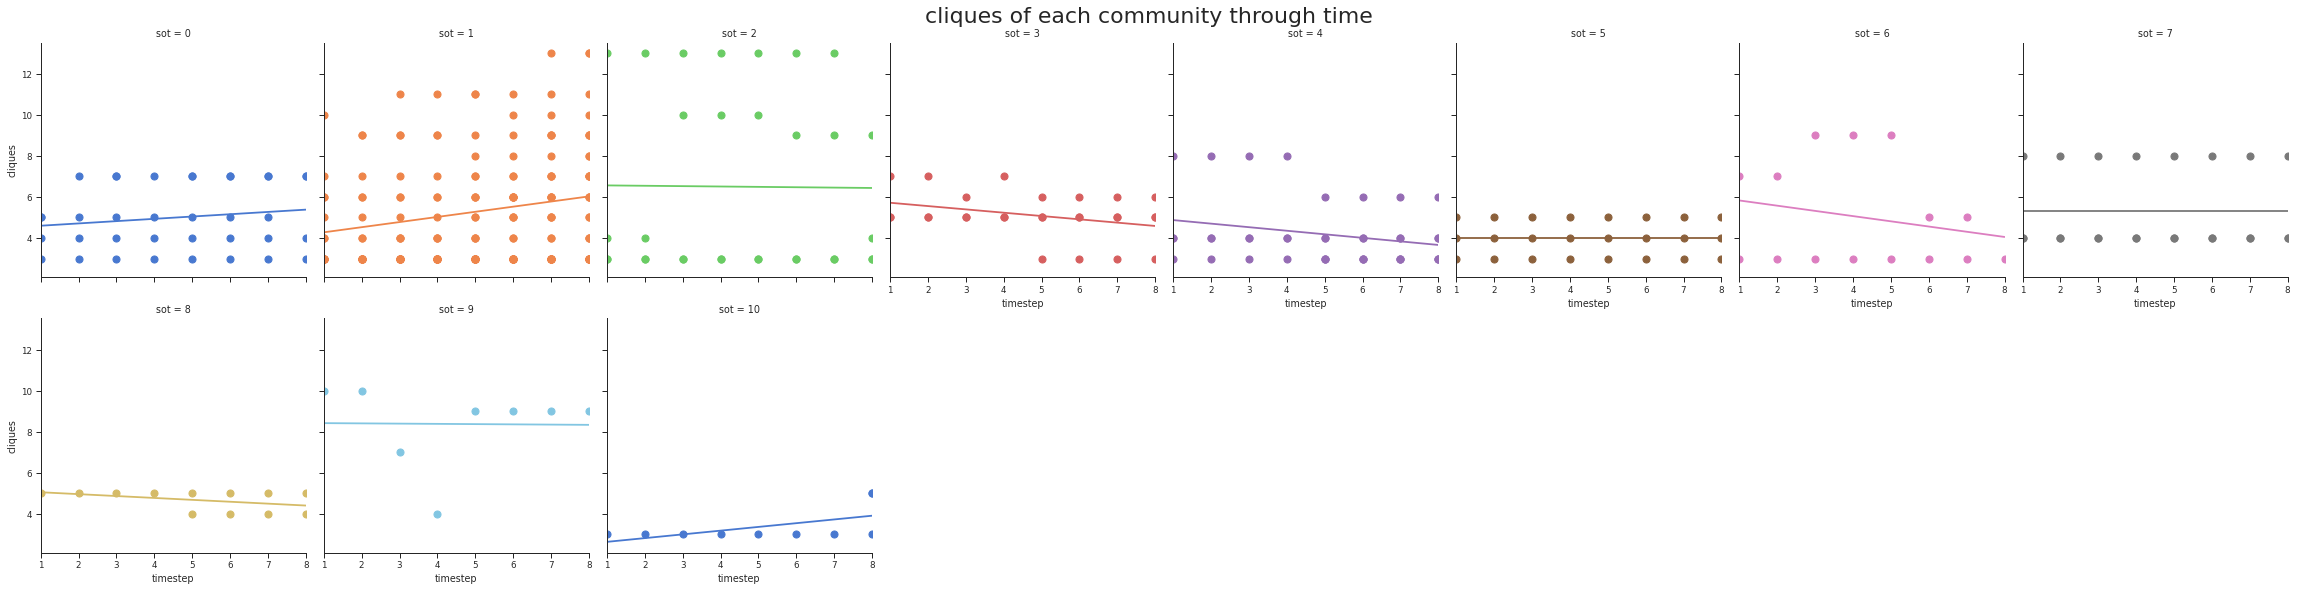

In [ ]:
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="cliques", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("cliques of each community through time", y=1.02, fontsize = 22)
plt.show()





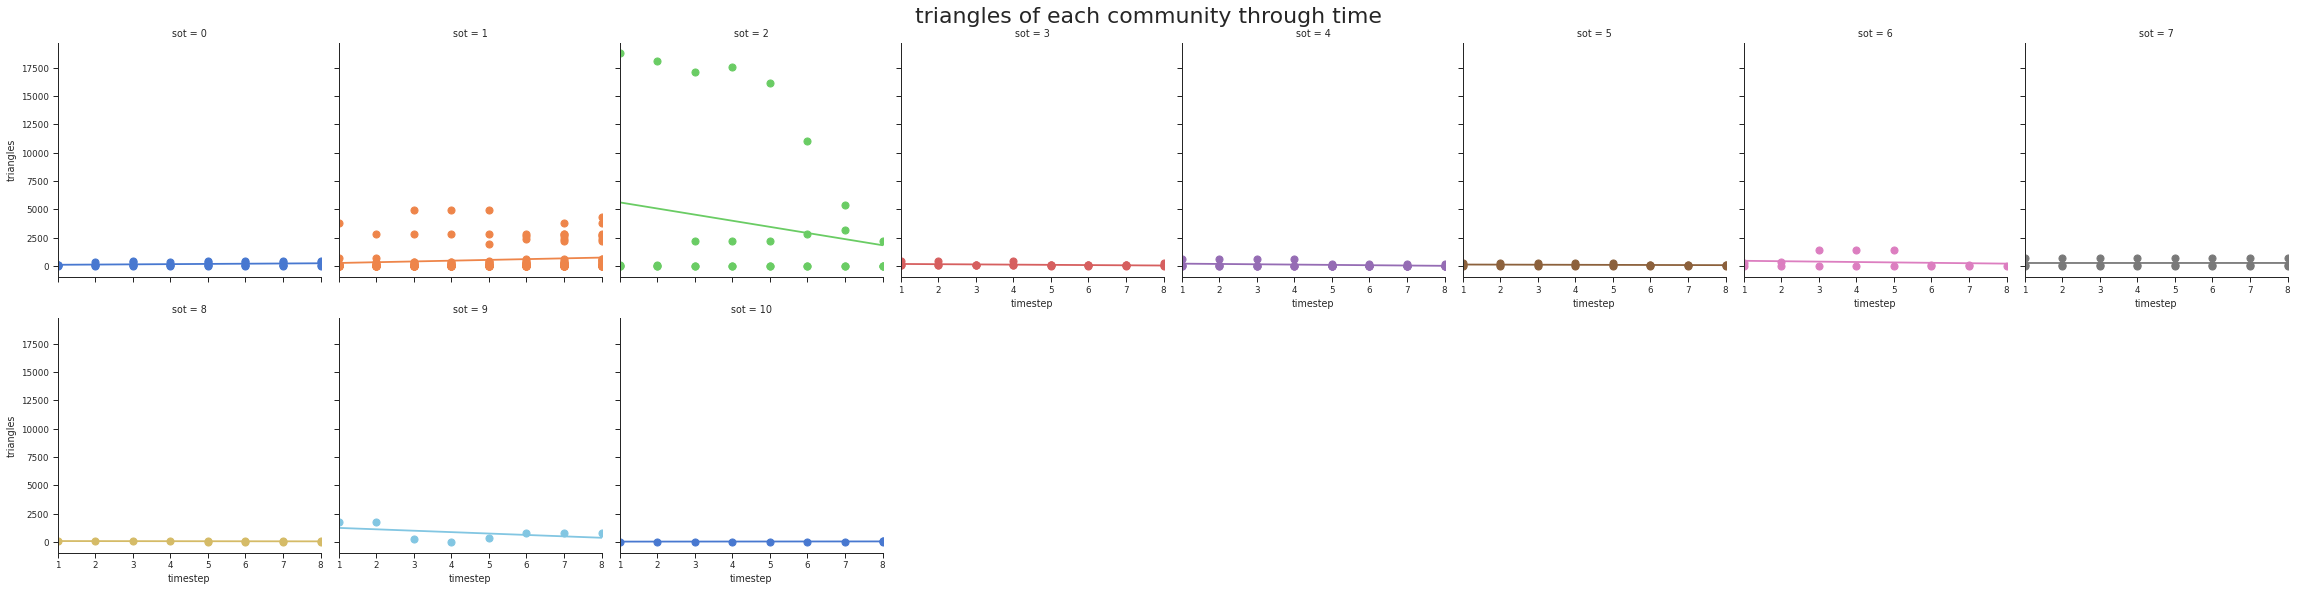

In [ ]:
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="triangles", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("triangles of each community through time", y=1.02, fontsize = 22)
plt.show()


## boundary and similar nodes in communities

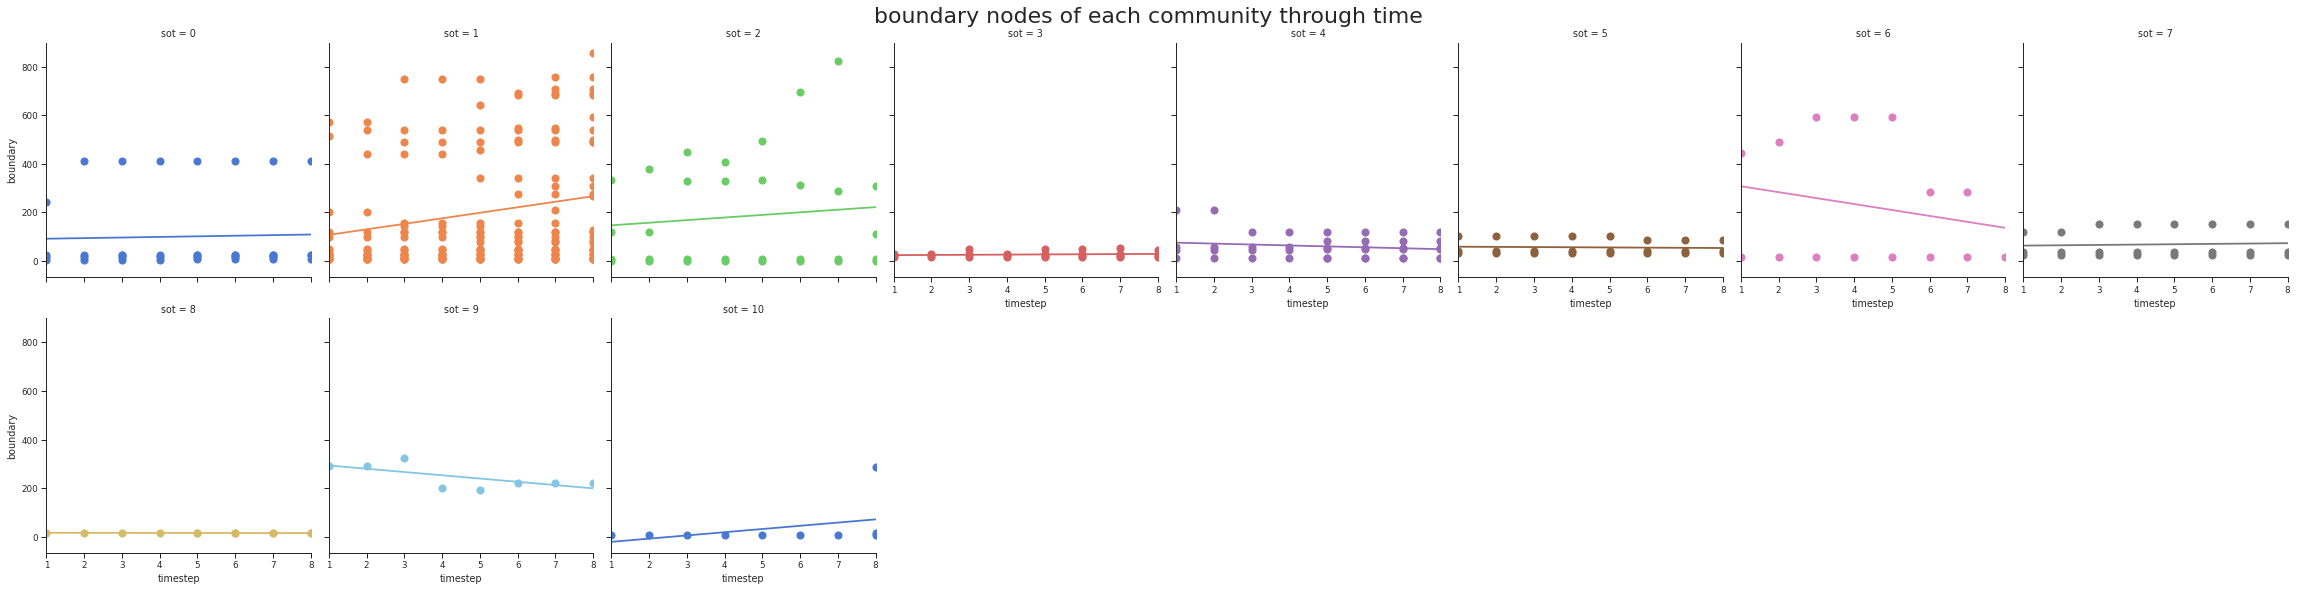

In [ ]:
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="boundary", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("boundary nodes of each community through time", y=1.02, fontsize = 22)
plt.show()


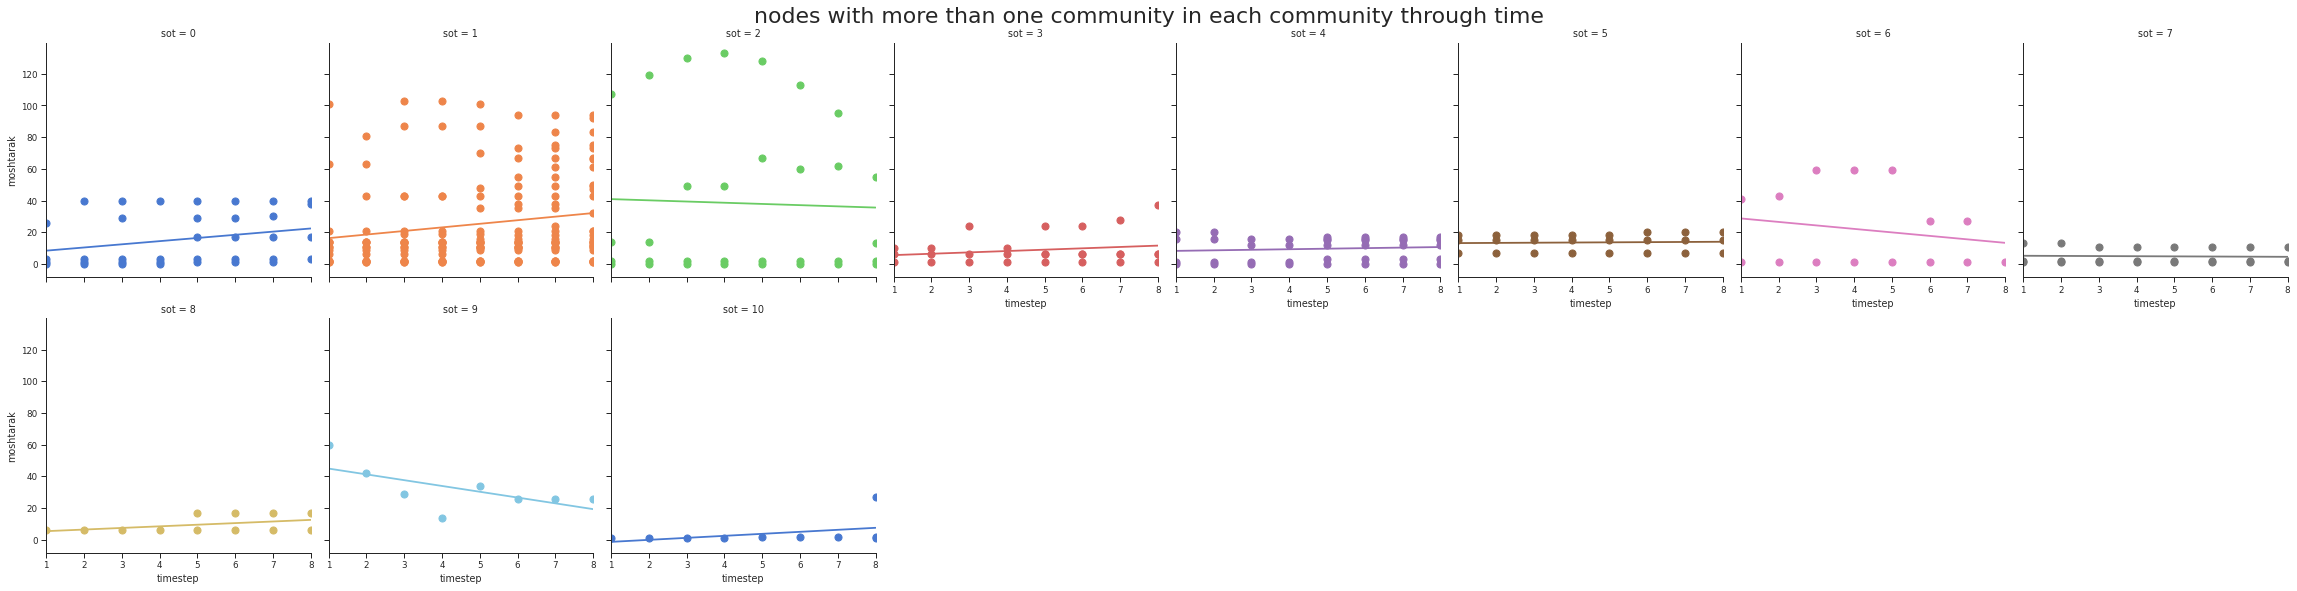

In [ ]:
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="moshtarak", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("nodes with more than one community in each community through time", y=1.02, fontsize = 22)
plt.show()


## diffusion of communities in time

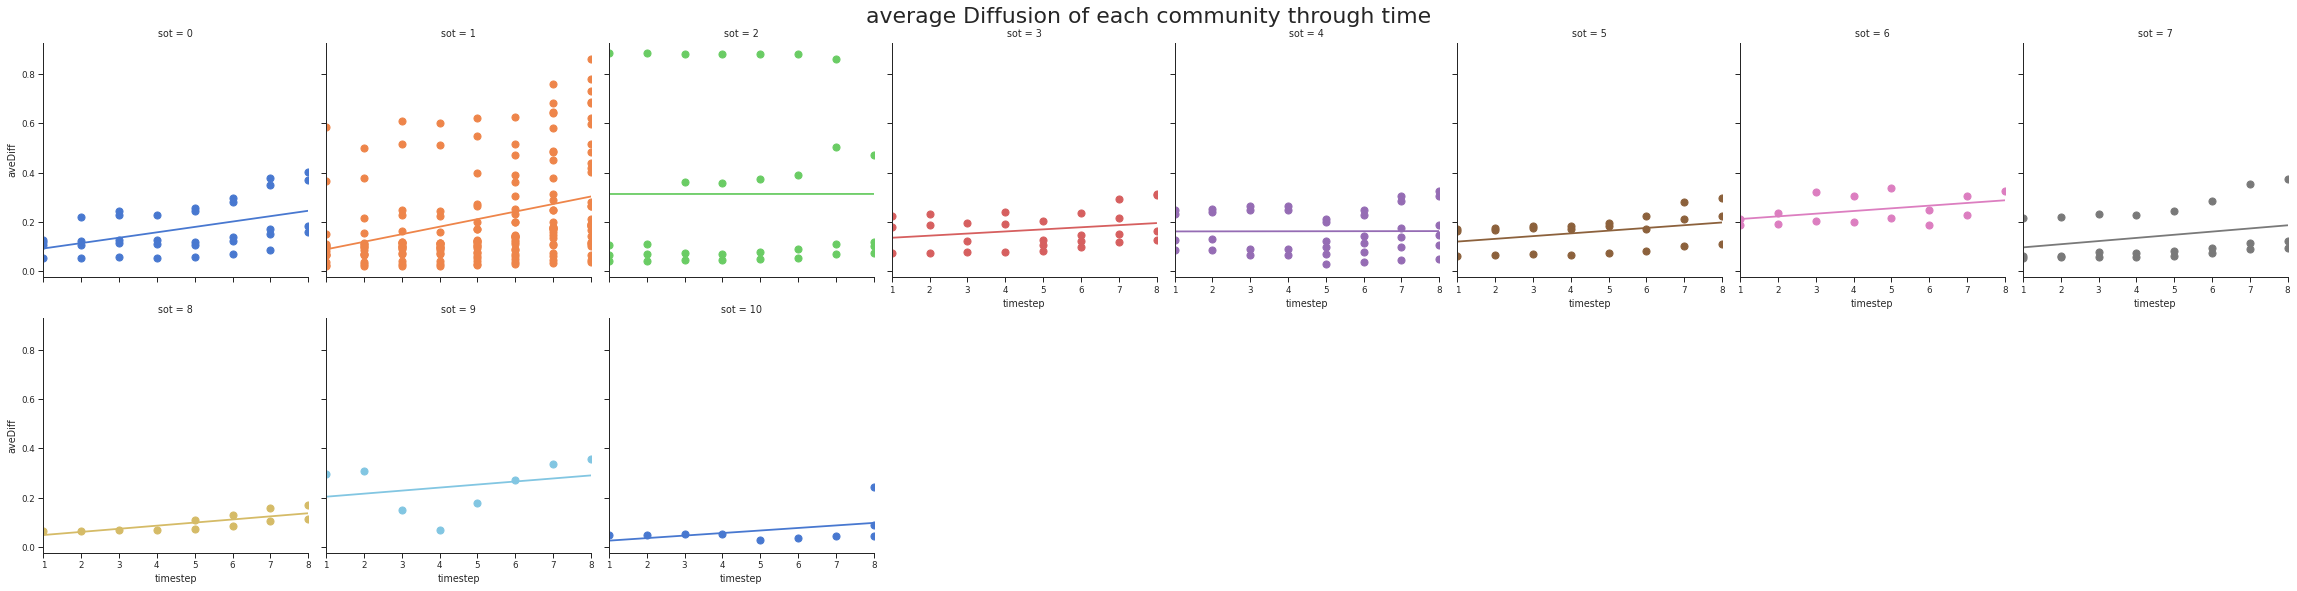

In [ ]:
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="aveDiff", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("average Diffusion of each community through time", y=1.02, fontsize = 22)
plt.show()


## distance to leader of communities in time


In [ ]:
df.head(2)

Unnamed: 0  numFol  numVol  diameter  ...    aveDis   aveDiff  label  timestep
0           0      20       4         4  ...  0.150943  0.104507      1         1
1           1      20      11         3  ...  0.125786  0.104075      2         1

[2 rows x 18 columns]

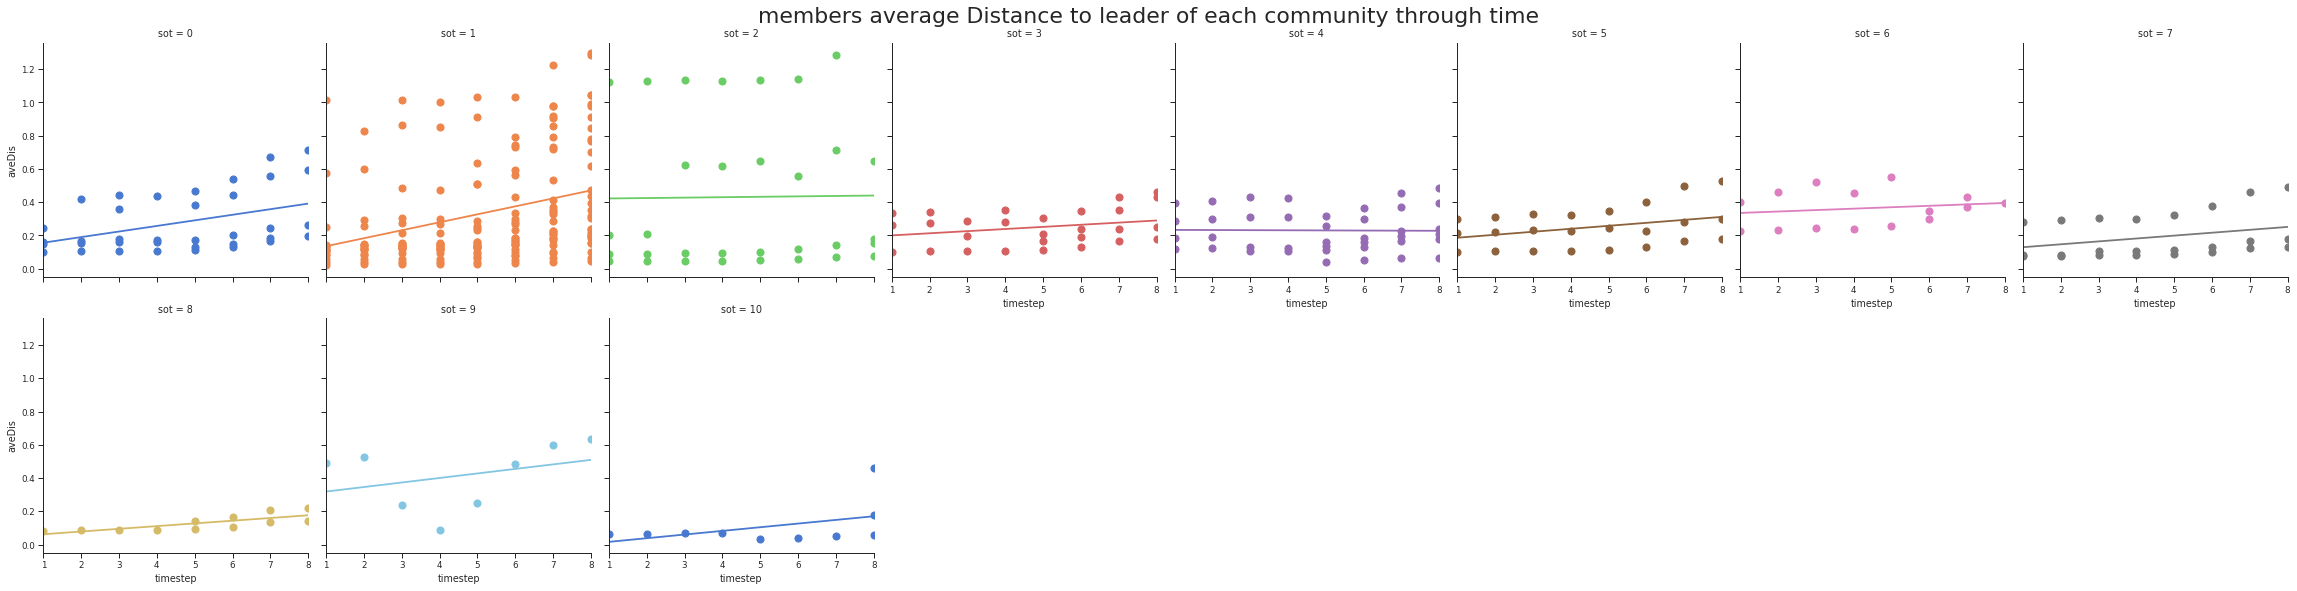

In [ ]:
import seaborn as sns



g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="aveDis", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("members average Distance to leader of each community through time", y=1.02, fontsize = 22)
plt.show()


## shortest path in communies through time

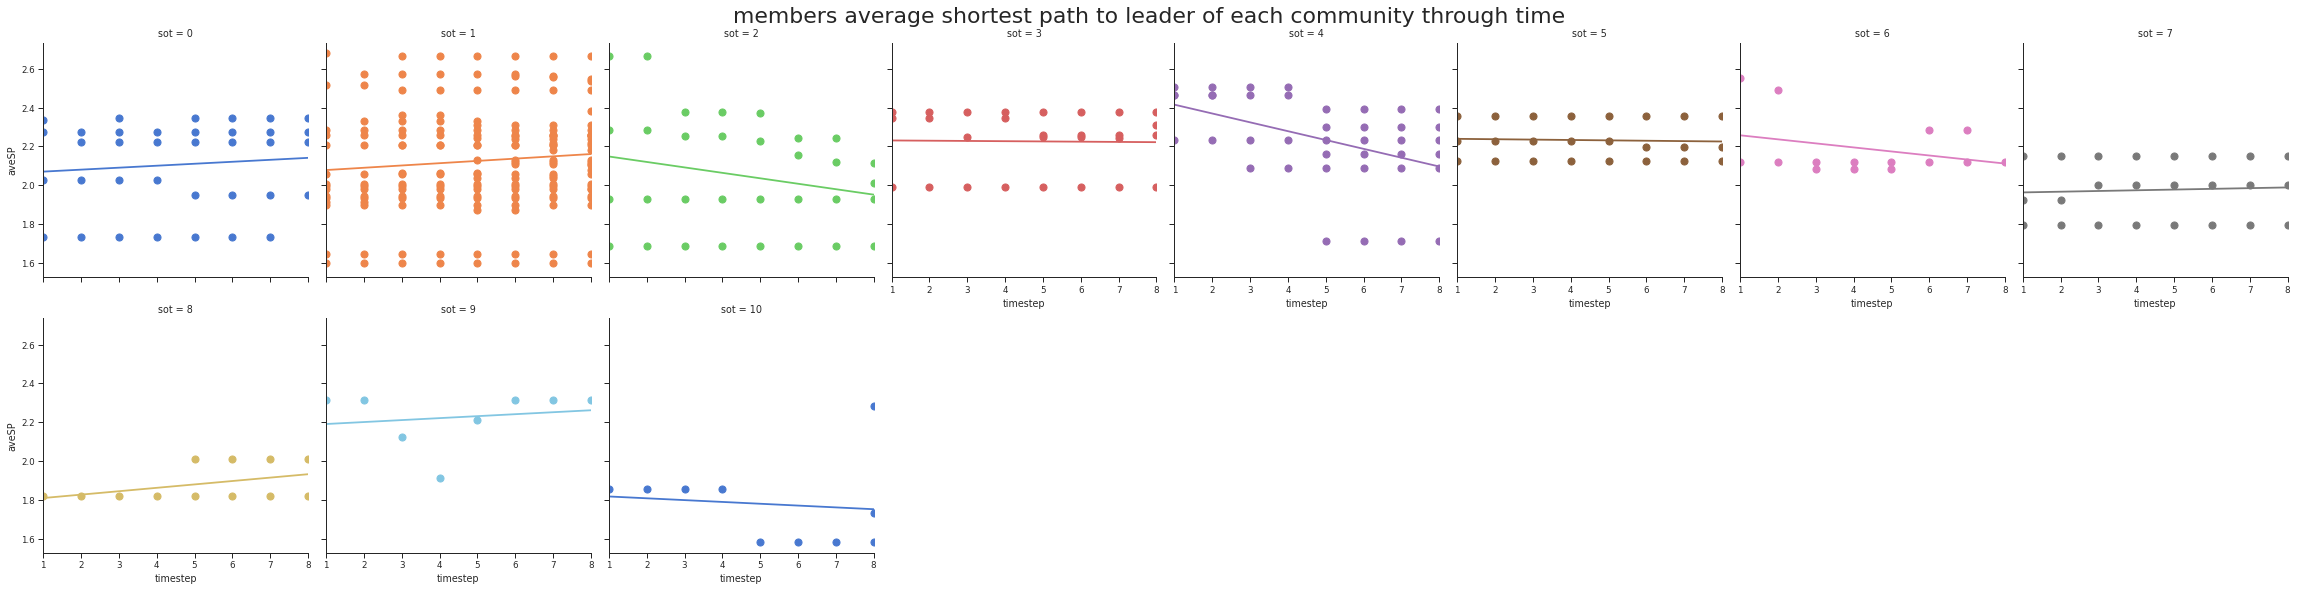

In [ ]:
import seaborn as sns

g = sns.set(style="ticks")
g = sns.set_context("paper")
g = sns.lmplot(x="timestep", y="aveSP", col="sot", hue="sot", data=df,
           col_wrap=8, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.fig.suptitle("members average shortest path to leader of each community through time", y=1.02, fontsize = 22)
plt.show()

## 123

In [ ]:
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

In [ ]:
1 -اختلاف ستون دوم از دیتاست راننده ھا در طول زمان نشان دھنده تغییر کلی در ھر بازه زمانی ھست
=> میتوان فھمید ھر چه در زمان به جلو میرویم نرخ تغییر اجتماعات چطور تغییر میکند - فقط دقت شود
این اختلاف قسمتی مربوط به کسانی ھست ک قبلا در ھیچ اجتماعی نبودند . قسمتی مربوط به
کسانی ھست که تغییر دادند که با یک شرط تفاوت پیدا میشود
2 -ایا نسبت تعداد لیدر ھا به فالوور ھا در طول زمان افزایشی است یا کاھشی یا ربطی ندارد
3 -پیدا کردن نرخ تغییر اجتماع توسط فالوور ھا و لیدر ھا بصورت جدا و مقایسه با ھم
4 -ایا کسانی که از رھبر اجتماعشون دور تر ھستند بیشتر تمایل به تغییر اجتماع دارند یا برعکس؟
5 -ایا کسانی که احتمال نشر پیام بالاتری دارند بیشتر تمایل به تغییر اجتماع دارند یا برعکس؟
7 -فالوور ھایی که معیار ھای مرکزیت (bet-eig-clo-deg (بیشتری دارند به مرور زمان رھبر میشنود؟
0 -کسانی که با اعضای بقیه کامیونیتی ھا ارتباطات بیشتری دارن احتمال نشر پیامشان کمتر ھست یا
بیشتر؟
# 6 -کسانی که ارتباطات بیشتری دارند ایا بیشتر ھم تمایل به تغییر اجتماع دارند؟
# 8 -کسانی که معیار ھای مرکزیت (clo-bet-eig-deg (بالاتری دارند بیشتر تمایل به تغییر اجتماع دارند یا
# برعکس؟
# 9 -رنک بندی اجتماعات با توجه به میزان ورود عضو جدید و اضافه کردن ستونی با عنوان جذابیت به جدول
# کامیونیتی ھ


# community tracking


## birth death

In [ ]:
import networkx as nx

G1 = nx.read_edgelist("/content/birthdeath.t01.edges")
G2 = nx.read_edgelist("/content/birthdeath.t02.edges")
G3 = nx.read_edgelist("/content/birthdeath.t03.edges")
G4 = nx.read_edgelist("/content/birthdeath.t04.edges")
G5 = nx.read_edgelist("/content/birthdeath.t05.edges")


# G1 = nx.read_edgelist("/content/expand.t01.edges")
# G2 = nx.read_edgelist("/content/expand.t02.edges")
# G3 = nx.read_edgelist("/content/expand.t03.edges")
# G4 = nx.read_edgelist("/content/expand.t04.edges")
# G5 = nx.read_edgelist("/content/expand.t05.edges")
-----

# G1 = nx.read_edgelist("/content/hide.t01.edges")
# G2 = nx.read_edgelist("/content/hide.t02.edges")
# G3 = nx.read_edgelist("/content/hide.t03.edges")
# G4 = nx.read_edgelist("/content/hide.t04.edges")
# G5 = nx.read_edgelist("/content/hide.t05.edges")

# G1 = nx.read_edgelist("/content/mergesplit.t01.edges")
# G2 = nx.read_edgelist("/content/mergesplit.t02.edges")
# G3 = nx.read_edgelist("/content/mergesplit.t03.edges")
# G4 = nx.read_edgelist("/content/mergesplit.t04.edges")
# G5 = nx.read_edgelist("/content/mergesplit.t05.edges")


In [ ]:
#communities

c1 = algorithms.louvain(G1).communities
c2 = algorithms.label_propagation(G1).communities
c3 = algorithms.kclique(G1, k=3).communities
# c4 = algorithms.big_clam(G1).communities
# c5 = algorithms.nmnf(G1).communities

In [ ]:
cd = "/content/birthdeath.t01.comm"
com = []
for line in open(cd):
    listcom = line.split(" ")
    listcom = listWords[:-1]
    com.append(listcom)

In [ ]:
import difflib
a=0
for i in range(len(com)):
    res = len(set(com[i]) & set(c1[i])) / float(len(set(com[i])|set(c1[i])))
    a = a + res
ratio = a/len(com)
ratioo = a/len(c1)


In [ ]:
len(com)

577

In [ ]:
len(c3)

657

# last valid
